#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링 
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.
    
* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

# 1. ML모델

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

## 1-2. ML 학습데이터 불러오기

In [13]:
data = pd.read_csv('data01_train.csv')
data = data.drop('subject', axis= 1)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [14]:
new_data = pd.read_csv('data01_test.csv')
new_data = new_data.drop('subject', axis = 1)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


## 1-3.데이터 전처리

In [17]:
data['Activity_dynamic'] = data['Activity'].apply(lambda x: 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)

In [18]:
new_data['Activity_dynamic'] = new_data['Activity'].apply(lambda x: 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)

In [19]:
data_sel = ['angle(X,gravityMean)','tGravityAcc-min()-X','tGravityAcc-energy()-X',
'tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-max()-Y',
'tGravityAcc-min()-Y','tGravityAcc-max()-X','angle(Y,gravityMean)',
'tBodyAccJerk-energy()-X','fBodyAccJerk-mad()-X','tBodyAccJerk-mad()-X',
'fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-1,16','tBodyAccJerk-std()-X',
'fBodyAccJerk-energy()-X','fBodyAccJerk-std()-X','tBodyAccJerk-entropy()-Y',
'tBodyAccJerk-entropy()-X','tGravityAcc-max()-Z','angle(Z,gravityMean)',
'tGravityAcc-min()-Z','tGravityAcc-energy()-Z','tGravityAcc-arCoeff()-X,1',
'fBodyAcc-bandsEnergy()-17,24.2','fBodyAccMag-std()','tBodyAcc-correlation()-X,Y',
'fBodyAcc-max()-X','tBodyGyroJerk-mad()-X','tGravityAccMag-mad()',
'fBodyBodyAccJerkMag-max()','fBodyAcc-std()-X','tGravityAcc-arCoeff()-Z,1',
'tGravityAcc-arCoeff()-Z,4','tGravityAcc-arCoeff()-Z,3','tGravityAcc-energy()-Y',
'tGravityAcc-arCoeff()-Y,2','fBodyGyro-maxInds-Z','tGravityAcc-arCoeff()-Y,4',
'fBodyAcc-meanFreq()-Z','tBodyAcc-mean()-X','fBodyAccJerk-skewness()-Y',
'fBodyAccJerk-maxInds-Z','fBodyAccJerk-meanFreq()-X','fBodyAccJerk-meanFreq()-Y',
'fBodyAccJerk-meanFreq()-Z','fBodyAccJerk-skewness()-X','fBodyAccJerk-kurtosis()-X',
'fBodyAccJerk-kurtosis()-Y','fBodyAccJerk-maxInds-X','Activity','Activity_dynamic']

data = data[data_sel]
new_data = new_data[data_sel]

In [20]:
target1 = 'Activity'
target2 = 'Activity_dynamic'

x_n = new_data.drop([target1, target2], axis = 1)
y1_n = new_data.loc[:,'Activity']
y2_n = new_data.loc[:,'Activity_dynamic']

In [21]:
xn_train, xn_val, yn1_train, yn1_val, yn2_train, yn2_val = train_test_split(x_n, y1_n, y2_n, test_size=.2, random_state=20)

In [22]:
scaler = MinMaxScaler()
xn_train = scaler.fit_transform(xn_train)
xn_val = scaler.transform(xn_val)

In [23]:
xn_train = pd.DataFrame(xn_train, columns=x_n.columns)
xn_val = pd.DataFrame(xn_val, columns=x_n.columns)

In [24]:
target1 = 'Activity'
target2 = 'Activity_dynamic'

x = data.drop([target1, target2], axis = 1)
y1 = data.loc[:,'Activity']
y2 = data.loc[:,'Activity_dynamic']

In [25]:
x1_train, x1_val, y1_train, y1_val, y2_train, y2_val = train_test_split(x, y1, y2, test_size=.2, random_state=20)

In [26]:
scaler = MinMaxScaler()
x1_train = scaler.fit_transform(x1_train)
x1_val = scaler.transform(x1_val)

In [27]:
x1_train = pd.DataFrame(x1_train, columns=x.columns)
x1_val = pd.DataFrame(x1_val, columns=x.columns)

## **1-4.단계별 모델링**

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [154]:
model_rf = RandomForestClassifier(random_state=1)

params = {'max_depth': range(1, 51),
          'n_estimators' : range(100, 200)}

model2 = RandomizedSearchCV(model_rf,
                           params,
                           cv=5,
                           n_iter=20,
                           scoring='accuracy')

model2.fit(x1_train, y2_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=20,
                   param_distributions={'max_depth': range(1, 51),
                                        'n_estimators': range(100, 200)},
                   scoring='accuracy')

In [155]:
model2.best_params_

{'n_estimators': 174, 'max_depth': 20}

In [160]:
model2 = RandomForestClassifier(max_depth=20, n_estimators=174, random_state=1)

model2.fit(x1_train, y2_train)

pred2 = model2.predict(x1_val)
print(confusion_matrix(y2_val, pred2))
print(classification_report(y2_val, pred2))

[[627   0]
 [  0 550]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       1.00      1.00      1.00       550

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [211]:
model2 = RandomForestClassifier(max_depth=20, n_estimators=174, random_state=1)

model2.fit(xn_train, yn2_train)

pred2 = model2.predict(xn_val)
print(confusion_matrix(yn2_val, pred2))
print(classification_report(yn2_val, pred2))

[[162   0]
 [  0 133]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       133

    accuracy                           1.00       295
   macro avg       1.00      1.00      1.00       295
weighted avg       1.00      1.00      1.00       295



### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [161]:
static_data = np.where(model2.predict(x1_train) == 0)

In [213]:
static_data1 = np.where(model2.predict(xn_train) == 0)

In [214]:
static_x = x1_train.iloc[static_data]
static_y = y1_train.iloc[static_data]
static = np.where((y1_val == 'LAYING') | (y1_val == 'STANDING') | (y1_val == 'SITTING'))
static_xv = x1_val.iloc[static]
static_yv = y1_val.iloc[static]
static_xv

,"angle(X,gravityMean)",tGravityAcc-min()-X,tGravityAcc-energy()-X,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-max()-Y,tGravityAcc-min()-Y,tGravityAcc-max()-X,"angle(Y,gravityMean)",tBodyAccJerk-energy()-X,...,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,fBodyAccJerk-maxInds-Z,fBodyAccJerk-meanFreq()-X,fBodyAccJerk-meanFreq()-Y,fBodyAccJerk-meanFreq()-Z,fBodyAccJerk-skewness()-X,fBodyAccJerk-kurtosis()-X,fBodyAccJerk-kurtosis()-Y,fBodyAccJerk-maxInds-X
0,0.220089,0.924262,0.798182,0.919569,0.453288,0.441433,0.439654,0.894945,0.658222,0.000044,...,0.526042,0.401137,0.530612,0.556101,0.400577,0.727216,0.314695,0.113029,0.213252,0.52
1,0.755830,0.314322,0.009549,0.313281,0.802698,0.820447,0.769630,0.321729,0.361301,0.007646,...,0.537069,0.174152,0.326531,0.523560,0.403729,0.347259,0.465504,0.207538,0.027381,0.54
4,0.678408,0.453049,0.055256,0.421363,0.958377,0.942354,0.967521,0.398301,0.137565,0.000028,...,0.520060,0.204705,0.265306,0.591874,0.441178,0.590014,0.207111,0.049211,0.031227,0.44
6,0.062570,0.992503,0.964619,0.986740,0.373992,0.346199,0.403187,0.945798,0.715338,0.000036,...,0.519077,0.311317,0.469388,0.576874,0.489163,0.750334,0.267627,0.065929,0.090775,0.22
7,0.112562,0.984016,0.946542,0.979742,0.188262,0.158892,0.222309,0.939214,0.846977,0.000567,...,0.517191,0.342172,0.142857,0.514320,0.203396,0.401003,0.153470,0.017312,0.094076,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,0.159547,0.968801,0.906610,0.964042,0.204241,0.179593,0.237248,0.927203,0.835154,0.000113,...,0.530998,0.255793,0.306122,0.480767,0.266188,0.664059,0.264554,0.077660,0.046813,0.14
1170,0.812473,0.271781,0.000186,0.233319,0.989715,0.974927,0.997289,0.220144,0.036751,0.000358,...,0.532665,0.284990,0.387755,0.373498,0.477341,0.504505,0.289363,0.111298,0.052560,0.36
1171,0.699176,0.424695,0.038869,0.392670,0.904100,0.887516,0.913650,0.370667,0.238314,0.000103,...,0.519292,0.214515,0.673469,0.628973,0.476134,0.416147,0.295177,0.108560,0.028208,0.28
1175,0.069259,0.989589,0.963977,0.986489,0.292929,0.274504,0.316324,0.948324,0.772751,0.000689,...,0.532314,0.277280,0.265306,0.400310,0.312959,0.438081,0.306105,0.075815,0.049448,0.18


In [215]:
static_xn = xn_train.iloc[static_data1]
static_yn = yn1_train.iloc[static_data1]
static = np.where((yn1_val == 'LAYING') | (yn1_val == 'STANDING') | (yn1_val == 'SITTING'))
static_xnv = xn_val.iloc[static]
static_ynv = yn1_val.iloc[static]
static_xnv

,"angle(X,gravityMean)",tGravityAcc-min()-X,tGravityAcc-energy()-X,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-max()-Y,tGravityAcc-min()-Y,tGravityAcc-max()-X,"angle(Y,gravityMean)",tBodyAccJerk-energy()-X,...,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,fBodyAccJerk-maxInds-Z,fBodyAccJerk-meanFreq()-X,fBodyAccJerk-meanFreq()-Y,fBodyAccJerk-meanFreq()-Z,fBodyAccJerk-skewness()-X,fBodyAccJerk-kurtosis()-X,fBodyAccJerk-kurtosis()-Y,fBodyAccJerk-maxInds-X
0,0.840120,0.224636,0.007359,0.201957,0.889786,0.886326,0.898016,0.173025,0.288284,0.000032,...,0.778113,0.179885,0.422222,0.719368,0.616131,0.757213,0.191041,0.051478,0.033972,0.50
2,0.746895,0.356182,0.009036,0.334898,0.900186,0.896198,0.907782,0.305855,0.266541,0.000050,...,0.782319,0.057912,0.488889,0.692961,0.614470,0.719223,0.485572,0.373795,0.005150,0.18
3,0.536900,0.402107,0.255113,0.584168,0.597665,0.676880,0.495186,0.899781,0.532206,0.014940,...,0.078213,0.260058,0.200000,0.289135,0.257077,0.178888,0.452855,0.252157,0.072169,0.08
4,0.127858,0.975707,0.928261,0.973374,0.319930,0.314785,0.370831,0.952381,0.758835,0.000020,...,0.783816,0.160523,0.222222,0.748474,0.430363,0.576003,0.256641,0.103203,0.032236,0.18
5,0.732765,0.375261,0.014927,0.354835,0.811702,0.807492,0.826043,0.326023,0.368786,0.000034,...,0.781335,0.154187,0.311111,0.819163,0.438601,0.636952,0.169577,0.050072,0.048070,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0.077685,0.991203,0.971265,0.989597,0.266671,0.261379,0.321727,0.968758,0.795996,0.000015,...,0.781279,0.104401,0.644444,0.694425,0.484156,0.739524,0.229021,0.056668,0.007423,0.42
290,0.880601,0.150240,0.026399,0.145803,0.197873,0.207244,0.235588,0.120551,0.845739,0.000179,...,0.784787,0.289540,0.266667,0.571890,0.118475,0.416934,0.301330,0.179480,0.094260,0.36
291,0.162774,0.961413,0.890497,0.958816,0.302707,0.298097,0.352138,0.938649,0.770868,0.001900,...,0.785381,0.205175,0.400000,0.617869,0.360075,0.298665,0.606754,0.433979,0.062260,0.38
292,0.805766,0.274769,0.000344,0.251353,0.735402,0.731101,0.755397,0.221092,0.442294,0.000059,...,0.784743,0.322263,0.400000,0.598006,0.546154,0.727562,0.336436,0.160670,0.129025,0.14


In [130]:
model_rf = RandomForestClassifier(random_state=1)

params = {'max_depth': range(1, 51),
          'n_estimators' : range(100, 200)}

model3 = RandomizedSearchCV(model_rf,
                           params,
                           cv=5,
                           n_iter=20,
                           scoring='accuracy') 

model3.fit(static_x, static_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=20,
                   param_distributions={'max_depth': range(1, 51),
                                        'n_estimators': range(100, 200)},
                   scoring='accuracy')

In [131]:
model3.best_params_

{'n_estimators': 158, 'max_depth': 34}

In [178]:
model3 = RandomForestClassifier(max_depth=34, n_estimators=158, random_state=1)

model3.fit(static_x, static_y)

pred3 = model3.predict(static_xv)
print(confusion_matrix(static_yv, pred3))
print(classification_report(static_yv, pred3))

[[202   0   0]
 [  0 201  10]
 [  0  10 204]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       202
     SITTING       0.95      0.95      0.95       211
    STANDING       0.95      0.95      0.95       214

    accuracy                           0.97       627
   macro avg       0.97      0.97      0.97       627
weighted avg       0.97      0.97      0.97       627



In [216]:
model3 = RandomForestClassifier(max_depth=34, n_estimators=158, random_state=1)

model3.fit(static_xn, static_yn)

pred3 = model3.predict(static_xnv)
print(confusion_matrix(static_ynv, pred3))
print(classification_report(static_ynv, pred3))

[[55  0  0]
 [ 0 37 11]
 [ 0  5 54]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00        55
     SITTING       0.88      0.77      0.82        48
    STANDING       0.83      0.92      0.87        59

    accuracy                           0.90       162
   macro avg       0.90      0.90      0.90       162
weighted avg       0.90      0.90      0.90       162



### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [191]:
dynamic_data = np.where(model2.predict(x1_train) == 1)

In [217]:
dynamic_data1 = np.where(model2.predict(xn_train) == 1)

In [192]:
dynamic_x = x1_train.iloc[dynamic_data]
dynamic_y = y1_train.iloc[dynamic_data]
dynamic = np.where((y1_val == 'WALKING') | (y1_val == 'WALKING_UPSTAIRS') | (y1_val == 'WALKING_DOWNSTAIRS'))
dynamic_xv = x1_val.iloc[dynamic]
dynamic_yv = y1_val.iloc[dynamic]
dynamic_xv

,"angle(X,gravityMean)",tGravityAcc-min()-X,tGravityAcc-energy()-X,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-max()-Y,tGravityAcc-min()-Y,tGravityAcc-max()-X,"angle(Y,gravityMean)",tBodyAccJerk-energy()-X,...,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,fBodyAccJerk-maxInds-Z,fBodyAccJerk-meanFreq()-X,fBodyAccJerk-meanFreq()-Y,fBodyAccJerk-meanFreq()-Z,fBodyAccJerk-skewness()-X,fBodyAccJerk-kurtosis()-X,fBodyAccJerk-kurtosis()-Y,fBodyAccJerk-maxInds-X
2,0.154923,0.962323,0.895098,0.959448,0.137085,0.111814,0.159047,0.925561,0.885069,0.202214,...,0.588551,0.284673,0.204082,0.302486,0.318529,0.491084,0.533756,0.273034,0.068892,0.24
3,0.198579,0.941986,0.843358,0.938450,0.090103,0.057409,0.126912,0.901576,0.920118,0.090325,...,0.517143,0.405660,0.020408,0.251441,0.158018,0.368824,0.453078,0.201909,0.140303,0.06
5,0.380879,0.795351,0.511802,0.784839,0.132635,0.115442,0.156886,0.766832,0.891345,0.085927,...,0.643301,0.301334,0.081633,0.360040,0.231984,0.107357,0.406411,0.168687,0.081255,0.08
8,0.062378,0.984826,0.966560,0.987478,0.254382,0.230470,0.279053,0.952731,0.800169,0.146061,...,0.481851,0.270983,0.408163,0.325058,0.220647,0.562153,0.445573,0.236274,0.056517,0.12
9,0.087199,0.987489,0.956370,0.983553,0.227870,0.205240,0.257696,0.945894,0.818974,0.093467,...,0.469763,0.343199,0.469388,0.187995,0.284688,0.473949,0.331679,0.120170,0.093237,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,0.094212,0.947567,0.878532,0.952685,0.217393,0.197542,0.240887,0.936771,0.829996,0.540776,...,0.632507,0.502796,0.367347,0.327832,0.283954,0.509078,0.556399,0.339089,0.234462,0.08
1169,0.145174,0.956650,0.908241,0.964576,0.157637,0.169397,0.171675,0.946477,0.869741,0.252867,...,0.495177,0.327564,0.346939,0.268971,0.233712,0.257775,0.508744,0.276043,0.088153,0.08
1172,0.110481,0.980517,0.939690,0.977071,0.242688,0.222474,0.270870,0.939058,0.808375,0.180116,...,0.496707,0.412988,0.326531,0.263053,0.406626,0.453426,0.584637,0.334711,0.150274,0.32
1173,0.226198,0.918971,0.786676,0.914689,0.188806,0.170721,0.215525,0.879781,0.848275,0.123477,...,0.554940,0.314055,0.061224,0.316881,0.306018,0.283506,0.375763,0.160450,0.084755,0.06


In [218]:
dynamic_xn = xn_train.iloc[dynamic_data1]
dynamic_yn = yn1_train.iloc[dynamic_data1]
dynamic = np.where((yn1_val == 'WALKING') | (yn1_val == 'WALKING_UPSTAIRS') | (yn1_val == 'WALKING_DOWNSTAIRS'))
dynamic_xnv = xn_val.iloc[dynamic]
dynamic_ynv = yn1_val.iloc[dynamic]
dynamic_xnv

,"angle(X,gravityMean)",tGravityAcc-min()-X,tGravityAcc-energy()-X,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-max()-Y,tGravityAcc-min()-Y,tGravityAcc-max()-X,"angle(Y,gravityMean)",tBodyAccJerk-energy()-X,...,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,fBodyAccJerk-maxInds-Z,fBodyAccJerk-meanFreq()-X,fBodyAccJerk-meanFreq()-Y,fBodyAccJerk-meanFreq()-Z,fBodyAccJerk-skewness()-X,fBodyAccJerk-kurtosis()-X,fBodyAccJerk-kurtosis()-Y,fBodyAccJerk-maxInds-X
1,0.218389,0.932555,0.826228,0.933305,0.165579,0.173390,0.211902,0.915662,0.866792,0.082241,...,0.780882,0.345333,0.333333,0.332032,0.279139,0.514507,0.530996,0.316032,0.143397,0.14
6,0.181536,0.946692,0.874687,0.952595,0.212664,0.221647,0.254430,0.940742,0.833723,0.344584,...,0.711044,0.350401,0.511111,0.300012,0.326567,0.373851,0.274940,0.088949,0.142569,0.08
8,0.093286,0.987998,0.970938,0.989472,0.192980,0.190655,0.237572,0.973750,0.847311,0.314360,...,0.693169,0.275428,0.444444,0.326609,0.179433,0.575233,0.233679,0.081708,0.102391,0.06
10,0.149175,0.973296,0.933910,0.975523,0.117345,0.115604,0.180486,0.957787,0.900046,0.283723,...,0.826593,0.330516,0.511111,0.459914,0.277805,0.516438,0.443280,0.204910,0.108406,0.24
11,0.118734,0.965448,0.925321,0.972239,0.147993,0.148627,0.205855,0.955603,0.880720,0.422172,...,0.900973,0.187979,0.444444,0.428466,0.295410,0.517135,0.380515,0.178691,0.045261,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,0.134642,0.958935,0.941702,0.978361,0.131936,0.150397,0.172192,0.975547,0.890196,0.108706,...,0.725465,0.323339,0.444444,0.381921,0.220126,0.136998,0.342708,0.120245,0.164772,0.14
286,0.146715,0.967455,0.909595,0.966215,0.175745,0.171654,0.235650,0.946155,0.860128,0.194188,...,0.829883,0.462768,0.444444,0.498414,0.342410,0.522145,0.758653,0.731835,0.258004,0.26
287,0.117700,0.979767,0.948461,0.981038,0.211380,0.214323,0.262893,0.963287,0.834493,0.339665,...,0.838817,0.451404,0.377778,0.395728,0.402168,0.325467,0.474416,0.280618,0.211985,0.34
289,0.113294,0.969809,0.938426,0.977225,0.381534,0.380863,0.423269,0.964525,0.715644,0.343617,...,0.836865,0.241438,0.288889,0.301486,0.262217,0.522926,0.765172,0.700991,0.061555,0.08


In [194]:
model_rf = RandomForestClassifier(random_state=1)

params = {'max_depth': range(1, 51),
          'n_estimators' : range(100, 200)}

model4 = RandomizedSearchCV(model_rf,
                           params,
                           cv=5,
                           n_iter=20,
                           scoring='accuracy') 

model4.fit(dynamic_x, dynamic_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=20,
                   param_distributions={'max_depth': range(1, 51),
                                        'n_estimators': range(100, 200)},
                   scoring='accuracy')

In [195]:
model4.best_params_

{'n_estimators': 161, 'max_depth': 14}

In [196]:
model4 = RandomForestClassifier(max_depth=14, n_estimators=161, random_state=1)

model4.fit(dynamic_x, dynamic_y)

pred4 = model4.predict(dynamic_xv)
print(confusion_matrix(dynamic_yv, pred4))
print(classification_report(dynamic_yv, pred4))

[[199   1   3]
 [  4 165   1]
 [  1   2 174]]
                    precision    recall  f1-score   support

           WALKING       0.98      0.98      0.98       203
WALKING_DOWNSTAIRS       0.98      0.97      0.98       170
  WALKING_UPSTAIRS       0.98      0.98      0.98       177

          accuracy                           0.98       550
         macro avg       0.98      0.98      0.98       550
      weighted avg       0.98      0.98      0.98       550



In [219]:
model4 = RandomForestClassifier(max_depth=14, n_estimators=161, random_state=1)

model4.fit(dynamic_xn, dynamic_yn)

pred4 = model4.predict(dynamic_xnv)
print(confusion_matrix(dynamic_ynv, pred4))
print(classification_report(dynamic_ynv, pred4))

[[40  0  3]
 [ 1 35  1]
 [ 1  1 51]]
                    precision    recall  f1-score   support

           WALKING       0.95      0.93      0.94        43
WALKING_DOWNSTAIRS       0.97      0.95      0.96        37
  WALKING_UPSTAIRS       0.93      0.96      0.94        53

          accuracy                           0.95       133
         macro avg       0.95      0.95      0.95       133
      weighted avg       0.95      0.95      0.95       133



# 2. DL 모델링

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Input, Dense, concatenate
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [224]:
data = pd.read_csv('data01_train.csv')
data.drop('subject', axis=1, inplace=True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [225]:
data = data.dropna()

In [226]:
new_data = pd.read_csv('data01_test.csv')
new_data.drop('subject', axis=1, inplace=True)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [227]:
new_data = new_data.dropna()

In [228]:
data_backup = data.copy()
new_data_backup = new_data.copy()

In [61]:
data = data_backup.copy()
new_data = new_data_backup.copy()

In [229]:
data = data[['tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,4', 'tGravityAcc-min()-Y', 'tGravityAcc-mean()-Y',
            'tGravityAcc-arCoeff()-Z,3', 'fBodyGyro-maxInds-Z', 'tGravityAcc-energy()-Y',
            'fBodyAccJerk-maxInds-Z', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Y,3',
            'tBodyAcc-max()-X', 'angle(Y,gravityMean)', 'tGravityAcc-max()-Y', 'fBodyAcc-max()-X',
            'fBodyAccMag-std()', 'fBodyAccJerk-bandsEnergy()-1,8', 'fBodyAcc-bandsEnergy()-1,8',
            'fBodyAcc-bandsEnergy()-1,24', 'tBodyAccJerkMag-iqr()', 'angle(X,gravityMean)', 'tBodyAcc-energy()-X',
            'tGravityAcc-energy()-X', 'fBodyAccMag-mad()', 'tGravityAcc-max()-Z', 'tGravityAcc-mean()-X',
            'fBodyAccMag-sma()', 'fBodyAccJerk-mean()-X', 'fBodyAccMag-energy()', 'tGravityAcc-max()-X',
            'tBodyAccJerk-sma()', 'tBodyAccJerkMag-entropy()', 'tBodyAccJerk-mad()-X', 'angle(Z,gravityMean)',
            'fBodyAcc-mean()-X', 'tBodyAccMag-std()', 'tBodyAccJerkMag-sma()', 'tGravityAcc-min()-X',
            'tGravityAcc-arCoeff()-X,2', 'tBodyGyroJerk-mad()-Z', 'tGravityAcc-min()-Z', 'tGravityAccMag-mad()',
            'fBodyAccMag-mean()', 'tGravityAccMag-std()', 'fBodyAccMag-entropy()', 'fBodyAcc-entropy()-X',
            'fBodyAcc-skewness()-X', 'tBodyGyroJerk-mad()-X', 'fBodyGyro-bandsEnergy()-17,32',
            'fBodyGyro-bandsEnergy()-17,32', 'fBodyGyro-bandsEnergy()-17,32', 'tBodyGyroJerk-std()-X', 'Activity']]
new_data = new_data[['tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,4', 'tGravityAcc-min()-Y', 'tGravityAcc-mean()-Y',
                    'tGravityAcc-arCoeff()-Z,3', 'fBodyGyro-maxInds-Z', 'tGravityAcc-energy()-Y',
                    'fBodyAccJerk-maxInds-Z', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Y,3',
                    'tBodyAcc-max()-X', 'angle(Y,gravityMean)', 'tGravityAcc-max()-Y', 'fBodyAcc-max()-X',
                    'fBodyAccMag-std()', 'fBodyAccJerk-bandsEnergy()-1,8', 'fBodyAcc-bandsEnergy()-1,8',
                    'fBodyAcc-bandsEnergy()-1,24', 'tBodyAccJerkMag-iqr()', 'angle(X,gravityMean)', 'tBodyAcc-energy()-X',
                    'tGravityAcc-energy()-X', 'fBodyAccMag-mad()', 'tGravityAcc-max()-Z', 'tGravityAcc-mean()-X',
                    'fBodyAccMag-sma()', 'fBodyAccJerk-mean()-X', 'fBodyAccMag-energy()', 'tGravityAcc-max()-X',
                    'tBodyAccJerk-sma()', 'tBodyAccJerkMag-entropy()', 'tBodyAccJerk-mad()-X', 'angle(Z,gravityMean)',
                    'fBodyAcc-mean()-X', 'tBodyAccMag-std()', 'tBodyAccJerkMag-sma()', 'tGravityAcc-min()-X',
                    'tGravityAcc-arCoeff()-X,2', 'tBodyGyroJerk-mad()-Z', 'tGravityAcc-min()-Z', 'tGravityAccMag-mad()',
                    'fBodyAccMag-mean()', 'tGravityAccMag-std()', 'fBodyAccMag-entropy()', 'fBodyAcc-entropy()-X',
                    'fBodyAcc-skewness()-X', 'tBodyGyroJerk-mad()-X', 'fBodyGyro-bandsEnergy()-17,32',
                    'fBodyGyro-bandsEnergy()-17,32', 'fBodyGyro-bandsEnergy()-17,32', 'tBodyGyroJerk-std()-X', 'Activity']]
print(data.shape)
print(new_data.shape)

(5881, 52)
(1471, 52)


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [230]:
dynamic_vals = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data['Activity_dynamic'] = np.where(data['Activity'].isin(dynamic_vals), 1, 0)
data.head()

,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,4",tGravityAcc-min()-Y,tGravityAcc-mean()-Y,"tGravityAcc-arCoeff()-Z,3",fBodyGyro-maxInds-Z,tGravityAcc-energy()-Y,fBodyAccJerk-maxInds-Z,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Y,3",tBodyAcc-max()-X,"angle(Y,gravityMean)",tGravityAcc-max()-Y,fBodyAcc-max()-X,fBodyAccMag-std(),"fBodyAccJerk-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,24",tBodyAccJerkMag-iqr(),"angle(X,gravityMean)",tBodyAcc-energy()-X,tGravityAcc-energy()-X,fBodyAccMag-mad(),tGravityAcc-max()-Z,tGravityAcc-mean()-X,fBodyAccMag-sma(),fBodyAccJerk-mean()-X,fBodyAccMag-energy(),tGravityAcc-max()-X,tBodyAccJerk-sma(),tBodyAccJerkMag-entropy(),tBodyAccJerk-mad()-X,"angle(Z,gravityMean)",fBodyAcc-mean()-X,tBodyAccMag-std(),tBodyAccJerkMag-sma(),tGravityAcc-min()-X,"tGravityAcc-arCoeff()-X,2",tBodyGyroJerk-mad()-Z,tGravityAcc-min()-Z,tGravityAccMag-mad(),fBodyAccMag-mean(),tGravityAccMag-std(),fBodyAccMag-entropy(),fBodyAcc-entropy()-X,fBodyAcc-skewness()-X,tBodyGyroJerk-mad()-X,"fBodyGyro-bandsEnergy()-17,32","fBodyGyro-bandsEnergy()-17,32","fBodyGyro-bandsEnergy()-17,32",tBodyGyroJerk-std()-X,Activity,Activity_dynamic
0,-0.386458,0.382783,-0.334921,-0.358842,-0.385893,-0.586207,-0.775936,-0.64,0.386323,-0.272900,-0.929747,0.331298,-0.370494,-0.989683,-0.981567,-0.999955,-0.999896,-0.999897,-0.991167,-0.601120,-0.999869,0.673768,-0.980498,-0.207900,0.875254,-0.985206,-0.987488,-0.999653,0.805627,-0.987305,-0.780976,-0.986926,0.165163,-0.987327,-0.981876,-0.987927,0.891969,0.425983,-0.985623,-0.210577,-0.983319,-0.985206,-0.981876,-0.816674,-0.907316,-0.199419,-0.986107,-0.999899,-0.999899,-0.999899,-0.985627,STANDING,0
1,0.021547,-0.016493,0.937432,0.924656,0.017077,-0.931034,0.714508,-0.48,-0.019327,0.028043,-0.937337,-0.769186,0.873312,-0.990635,-0.992435,-0.999961,-0.999897,-0.999900,-0.992502,0.345205,-0.999873,-0.893830,-0.990134,0.227824,-0.134711,-0.989450,-0.989638,-0.999866,-0.200892,-0.991559,-0.802606,-0.990986,-0.147944,-0.989000,-0.990870,-0.990842,-0.095343,0.581649,-0.990121,0.235139,-0.991058,-0.989450,-0.990870,-0.946182,-0.873892,-0.235336,-0.992184,-0.999959,-0.999959,-0.999959,-0.991568,LAYING,0
2,0.075337,0.011423,-0.145801,-0.174095,0.015440,-1.000000,-0.953043,0.08,-0.044970,0.152300,-0.942584,0.202434,-0.195671,-0.998989,-0.994252,-0.999996,-0.999995,-0.999991,-0.988206,-0.833564,-0.999988,0.906252,-0.991574,0.069356,0.965965,-0.990805,-0.994936,-0.999897,0.891615,-0.988320,-0.771642,-0.994091,-0.032755,-0.996881,-0.992562,-0.988080,0.985606,0.124078,-0.990426,0.080422,-0.992451,-0.990805,-0.992562,-1.000000,-1.000000,-0.650195,-0.984787,-0.999856,-0.999856,-0.999856,-0.985597,STANDING,0
3,-0.352702,0.464018,-0.275699,-0.297703,-0.430046,-0.655172,-0.849096,-0.44,0.392060,-0.318939,0.008288,0.287154,-0.309430,-0.360129,-0.575620,-0.769630,-0.721128,-0.702681,-0.344531,-0.695819,-0.703590,0.805419,-0.489603,-0.127354,0.927343,-0.407268,-0.316202,-0.850144,0.858160,-0.234347,0.720619,-0.194729,0.111388,-0.195753,-0.459911,-0.255250,0.943954,0.409655,-0.419305,-0.140344,-0.549845,-0.407268,-0.459911,0.340417,0.539209,-0.151351,-0.363761,-0.802218,-0.802218,-0.802218,-0.376572,WALKING,1
4,-0.769572,0.798089,-0.263482,-0.260540,-0.790986,-0.586207,-0.885215,-0.48,0.780440,-0.594359,0.584131,0.264952,-0.236084,-0.018083,-0.049606,-0.510367,-0.361775,-0.401148,-0.347047,-0.705029,-0.404271,0.738738,0.206229,-0.080139,0.901125,0.191831,-0.159198,-0.330888,0.858531,-0.378101,0.664467,-0.146586,0.137758,0.066819,0.152179,-0.350500,0.901943,0.766281,-0.634217,-0.230767,-0.031905,0.191831,0.152179,0.676679,0.565149,0.030987,-0.554993,-0.924813,-0.924813,-0.924813,-0.528445,WALKING_DOWNSTAIRS,1


In [65]:
target_y1 = 'Activity'
target_y2 = 'Activity_dynamic'
x = data.drop([target_y1, target_y2], axis=1)
y1 = data.loc[:, target_y1]
y2 = data.loc[:, target_y2]

In [66]:
x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size=.3)
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size=.3)
print(x_train.shape, x_test.shape)
print(y1_train.shape, y1_test.shape)
print(y2_train.shape, y2_test.shape)

(2908, 561) (1247, 561)
(2908,) (1247,)
(2908,) (1247,)


## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

In [24]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 : DeepLearning

In [68]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

In [69]:
nfeatures = x_train_s.shape[1]

model_dl = Sequential([Dense(8, input_shape=(nfeatures,), activation='relu'),
                    Dense(1, activation='sigmoid')])

model_dl.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 4496      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4505 (17.60 KB)
Trainable params: 4505 (17.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
model_dl.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
hist = model_dl.fit(x_train_s, y2_train, epochs=100, validation_split=.2).history

Epoch 1/100
73/73 [==============================] - 1s 7ms/step - loss: 0.5487 - val_loss: 0.4040
Epoch 2/100
73/73 [==============================] - 0s 5ms/step - loss: 0.3310 - val_loss: 0.2725
Epoch 3/100
73/73 [==============================] - 0s 5ms/step - loss: 0.2222 - val_loss: 0.1889
Epoch 4/100
73/73 [==============================] - 0s 5ms/step - loss: 0.1584 - val_loss: 0.1401
Epoch 5/100
73/73 [==============================] - 0s 4ms/step - loss: 0.1195 - val_loss: 0.1088
Epoch 6/100
73/73 [==============================] - 0s 3ms/step - loss: 0.0940 - val_loss: 0.0874
Epoch 7/100
73/73 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0722
Epoch 8/100
73/73 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0609
Epoch 9/100
73/73 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0524
Epoch 10/100
73/73 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0454
Epoch 11/

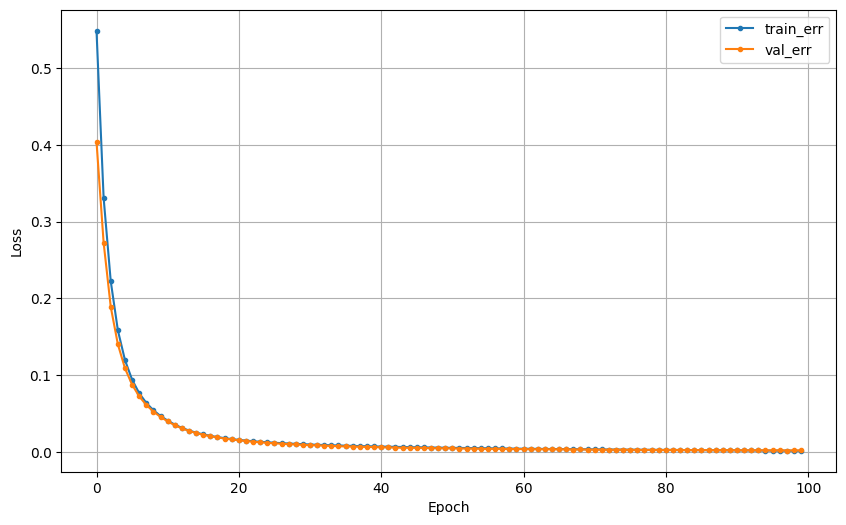

In [71]:
dl_history_plot(hist)

In [76]:
pred_dl = model_dl.predict(x_test_s)
pred_dl = np.where(pred_dl > .5, 1, 0)
print(confusion_matrix(y2_test, pred_dl))
print(classification_report(y2_test, pred_dl))

39/39 [==============================] - 0s 3ms/step
[[698   0]
 [  0 549]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       549

    accuracy                           1.00      1247
   macro avg       1.00      1.00      1.00      1247
weighted avg       1.00      1.00      1.00      1247



#### 2) 알고리즘2 :

In [48]:
model_rf = RandomForestClassifier(max_depth=5, n_estimators=100)

In [73]:
model_rf.fit(x_train, y2_train)

RandomForestClassifier(max_depth=5)

In [78]:
pred_rf = model_rf.predict(x_test)
print(confusion_matrix(y2_test, pred_rf))
print(classification_report(y2_test, pred_rf))

[[698   0]
 [  0 549]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       698
           1       1.00      1.00      1.00       549

    accuracy                           1.00      1247
   macro avg       1.00      1.00      1.00      1247
weighted avg       1.00      1.00      1.00      1247



### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [85]:
data_static = data.loc[data['Activity_dynamic'] == 0]
data_static.reset_index(drop=True, inplace=True)
data_static.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [89]:
x_static = data_static.drop(['Activity', 'Activity_dynamic'], axis=1)
y_static = data_static['Activity'].map({'LAYING':0,
                                 'SITTING':1,
                                 'STANDING':2})

In [103]:
x_static_train, x_static_test, y_static_train, y_static_test = train_test_split(x_static, y_static, test_size=.3)
x_static_train = scaler.fit_transform(x_static_train)
x_static_test = scaler.transform(x_static_test)

In [171]:
model_dl_static = Sequential([Dense(12, input_shape=(nfeatures,), activation='relu'),
                              Dense(6, activation='relu'),
                              Dense(3, activation='softmax')])
model_dl_static.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 12)                6744      
                                                                 
 dense_43 (Dense)            (None, 6)                 78        
                                                                 
 dense_44 (Dense)            (None, 3)                 21        
                                                                 
Total params: 6843 (26.73 KB)
Trainable params: 6843 (26.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [172]:
model_dl_static.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy')

In [173]:
hist_static = model_dl_static.fit(x_static_train, y_static_train, epochs=150, validation_split=.2).history

Epoch 1/150
40/40 [==============================] - 2s 13ms/step - loss: 1.0758 - val_loss: 1.0505
Epoch 2/150
40/40 [==============================] - 0s 5ms/step - loss: 1.0092 - val_loss: 0.9743
Epoch 3/150
40/40 [==============================] - 0s 5ms/step - loss: 0.9313 - val_loss: 0.9016
Epoch 4/150
40/40 [==============================] - 0s 5ms/step - loss: 0.8697 - val_loss: 0.8461
Epoch 5/150
40/40 [==============================] - 0s 6ms/step - loss: 0.8153 - val_loss: 0.7965
Epoch 6/150
40/40 [==============================] - 0s 6ms/step - loss: 0.7638 - val_loss: 0.7478
Epoch 7/150
40/40 [==============================] - 0s 6ms/step - loss: 0.7101 - val_loss: 0.6964
Epoch 8/150
40/40 [==============================] - 0s 7ms/step - loss: 0.6595 - val_loss: 0.6509
Epoch 9/150
40/40 [==============================] - 0s 9ms/step - loss: 0.6144 - val_loss: 0.6086
Epoch 10/150
40/40 [==============================] - 0s 5ms/step - loss: 0.5737 - val_loss: 0.5721
Epoch 11

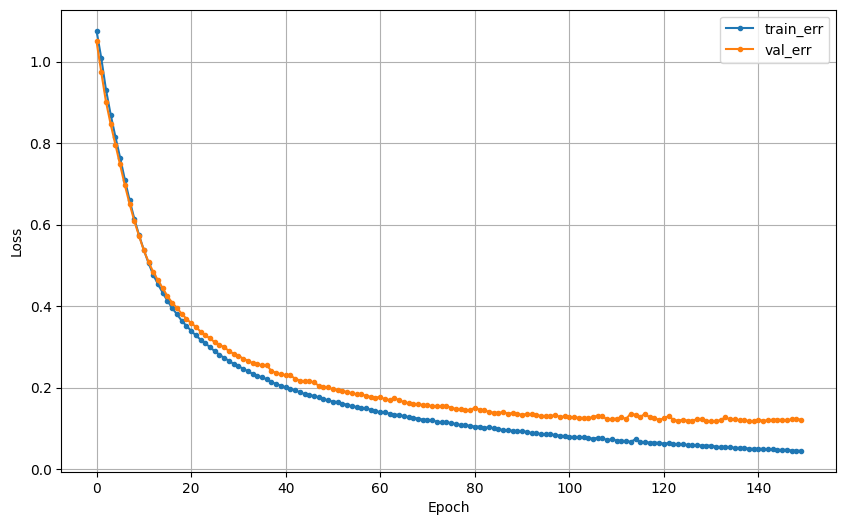

In [174]:
dl_history_plot(hist_static)

In [175]:
pred_dl_static = model_dl_static.predict(x_static_test)
pred_dl_static = pred_dl_static.argmax(axis=1)
print(confusion_matrix(y_static_test, pred_dl_static))
print(classification_report(y_static_test, pred_dl_static))

22/22 [==============================] - 0s 2ms/step
[[229   0   1]
 [  3 198  16]
 [  0  19 216]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       230
           1       0.91      0.91      0.91       217
           2       0.93      0.92      0.92       235

    accuracy                           0.94       682
   macro avg       0.94      0.94      0.94       682
weighted avg       0.94      0.94      0.94       682



### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [257]:
data_dynamic = data.loc[data['Activity_dynamic'] == 1]
data_dynamic.reset_index(drop=True, inplace=True)
data_dynamic.head()

,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,4",tGravityAcc-min()-Y,tGravityAcc-mean()-Y,"tGravityAcc-arCoeff()-Z,3",fBodyGyro-maxInds-Z,tGravityAcc-energy()-Y,fBodyAccJerk-maxInds-Z,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Y,3",tBodyAcc-max()-X,"angle(Y,gravityMean)",tGravityAcc-max()-Y,fBodyAcc-max()-X,fBodyAccMag-std(),"fBodyAccJerk-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,24",tBodyAccJerkMag-iqr(),"angle(X,gravityMean)",tBodyAcc-energy()-X,tGravityAcc-energy()-X,fBodyAccMag-mad(),tGravityAcc-max()-Z,tGravityAcc-mean()-X,fBodyAccMag-sma(),fBodyAccJerk-mean()-X,fBodyAccMag-energy(),tGravityAcc-max()-X,tBodyAccJerk-sma(),tBodyAccJerkMag-entropy(),tBodyAccJerk-mad()-X,"angle(Z,gravityMean)",fBodyAcc-mean()-X,tBodyAccMag-std(),tBodyAccJerkMag-sma(),tGravityAcc-min()-X,"tGravityAcc-arCoeff()-X,2",tBodyGyroJerk-mad()-Z,tGravityAcc-min()-Z,tGravityAccMag-mad(),fBodyAccMag-mean(),tGravityAccMag-std(),fBodyAccMag-entropy(),fBodyAcc-entropy()-X,fBodyAcc-skewness()-X,tBodyGyroJerk-mad()-X,"fBodyGyro-bandsEnergy()-17,32","fBodyGyro-bandsEnergy()-17,32","fBodyGyro-bandsEnergy()-17,32",tBodyGyroJerk-std()-X,Activity,Activity_dynamic
0,-0.352702,0.464018,-0.275699,-0.297703,-0.430046,-0.655172,-0.849096,-0.44,0.392060,-0.318939,0.008288,0.287154,-0.309430,-0.360129,-0.575620,-0.769630,-0.721128,-0.702681,-0.344531,-0.695819,-0.703590,0.805419,-0.489603,-0.127354,0.927343,-0.407268,-0.316202,-0.850144,0.858160,-0.234347,0.720619,-0.194729,0.111388,-0.195753,-0.459911,-0.255250,0.943954,0.409655,-0.419305,-0.140344,-0.549845,-0.407268,-0.459911,0.340417,0.539209,-0.151351,-0.363761,-0.802218,-0.802218,-0.802218,-0.376572,WALKING,1
1,-0.769572,0.798089,-0.263482,-0.260540,-0.790986,-0.586207,-0.885215,-0.48,0.780440,-0.594359,0.584131,0.264952,-0.236084,-0.018083,-0.049606,-0.510367,-0.361775,-0.401148,-0.347047,-0.705029,-0.404271,0.738738,0.206229,-0.080139,0.901125,0.191831,-0.159198,-0.330888,0.858531,-0.378101,0.664467,-0.146586,0.137758,0.066819,0.152179,-0.350500,0.901943,0.766281,-0.634217,-0.230767,-0.031905,0.191831,0.152179,0.676679,0.565149,0.030987,-0.554993,-0.924813,-0.924813,-0.924813,-0.528445,WALKING_DOWNSTAIRS,1
2,-0.587357,0.767819,-0.230180,-0.245363,-0.710203,-0.931034,-0.900090,-0.88,0.648983,-0.476659,-0.019263,0.253885,-0.244249,-0.156071,-0.318918,-0.773946,-0.641024,-0.684994,-0.383774,-0.552729,-0.690676,0.554358,-0.154085,-0.370443,0.826207,-0.181485,-0.326026,-0.666117,0.760409,-0.220044,0.719128,-0.314495,0.291256,-0.296175,-0.188850,-0.230553,0.839064,0.620927,-0.478733,-0.384927,-0.242772,-0.181485,-0.188850,0.542752,0.543654,0.408653,-0.530156,-0.903635,-0.903635,-0.903635,-0.508160,WALKING_UPSTAIRS,1
3,-0.663782,0.754734,-0.126153,-0.131379,-0.726669,-0.586207,-0.975107,0.16,0.695328,-0.407805,0.114668,0.173338,-0.143458,-0.442791,-0.360095,-0.680432,-0.620083,-0.637599,-0.365698,-0.886603,-0.634559,0.929449,-0.203425,0.065414,0.974673,-0.223147,-0.223459,-0.702409,0.913568,-0.233812,0.753136,-0.209311,-0.005627,-0.163822,-0.234869,-0.228956,0.978842,0.679668,-0.556777,0.007718,-0.319488,-0.223147,-0.234869,0.467057,0.639858,-0.258729,-0.495309,-0.900107,-0.900107,-0.900107,-0.495138,WALKING,1
4,-0.173693,0.243199,-0.243260,-0.266212,-0.224235,-0.586207,-0.881165,-0.08,0.200315,-0.164396,-0.000818,0.266729,-0.277085,-0.258561,-0.316897,-0.625549,-0.620914,-0.648713,-0.409914,-0.752882,-0.653118,0.830890,-0.106592,-0.032913,0.937195,-0.075130,-0.244275,-0.627778,0.872634,-0.081086,0.759089,-0.119598,0.045692,-0.236663,-0.142998,-0.101618,0.952754,0.520902,-0.336113,-0.042619,-0.239224,-0.075130,-0.142998,0.534301,0.651331,0.047534,-0.195158,-0.719174,-0.719174,-0.719174,-0.195160,WALKING,1


In [258]:
x_dynamic = data_dynamic.drop(['Activity', 'Activity_dynamic'], axis=1)
y_dynamic = data_dynamic['Activity'].map({'WALKING':0,
                                 'WALKING_UPSTAIRS':1,
                                 'WALKING_DOWNSTAIRS':2})

In [259]:
x_dynamic.shape, y_dynamic.shape

((2647, 51), (2647,))

In [260]:
x_dynamic_train, x_dynamic_test, y_dynamic_train, y_dynamic_test = train_test_split(x_dynamic, y_dynamic, test_size=.3)
x_dynamic_train = scaler.fit_transform(x_dynamic_train)
x_dynamic_test = scaler.transform(x_dynamic_test)

In [298]:
clear_session()
model_dl_dynamic = Sequential([Dense(8, input_shape=(51,), activation='relu'),
                              #  Dense(6, activation='relu'),
                              Dense(3, activation='softmax')])
model_dl_dynamic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 416       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 443 (1.73 KB)
Trainable params: 443 (1.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [299]:
model_dl_dynamic.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy')

In [300]:
hist_dynamic = model_dl_dynamic.fit(x_dynamic_train, y_dynamic_train, epochs=200, validation_split=.2).history

Epoch 1/200
47/47 [==============================] - 2s 20ms/step - loss: 1.1329 - val_loss: 1.0943
Epoch 2/200
47/47 [==============================] - 1s 11ms/step - loss: 1.0831 - val_loss: 1.0619
Epoch 3/200
47/47 [==============================] - 1s 13ms/step - loss: 1.0547 - val_loss: 1.0389
Epoch 4/200
47/47 [==============================] - 0s 8ms/step - loss: 1.0342 - val_loss: 1.0211
Epoch 5/200
47/47 [==============================] - 0s 7ms/step - loss: 1.0163 - val_loss: 1.0043
Epoch 6/200
47/47 [==============================] - 0s 10ms/step - loss: 0.9993 - val_loss: 0.9883
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.9828 - val_loss: 0.9720
Epoch 8/200
47/47 [==============================] - 1s 12ms/step - loss: 0.9664 - val_loss: 0.9561
Epoch 9/200
47/47 [==============================] - 1s 11ms/step - loss: 0.9503 - val_loss: 0.9395
Epoch 10/200
47/47 [==============================] - 0s 9ms/step - loss: 0.9340 - val_loss: 0.9234
Epo

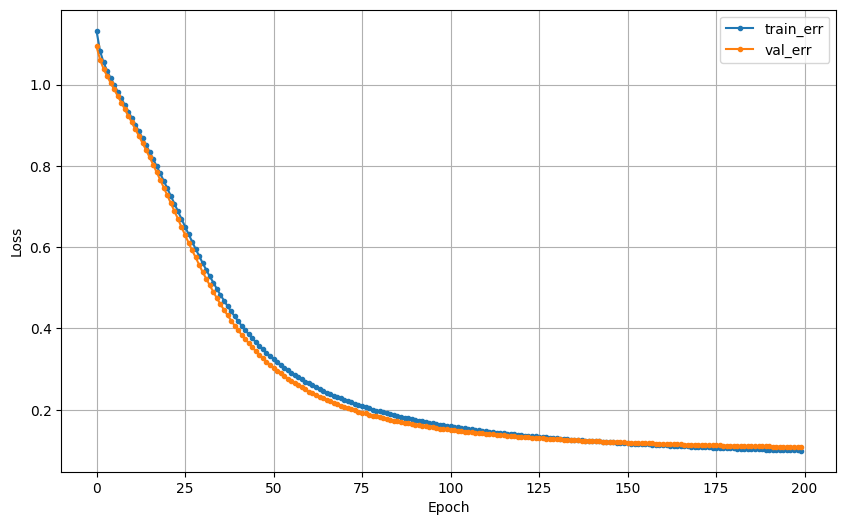

In [301]:
dl_history_plot(hist_dynamic)

In [302]:
pred_dl_dynamic = model_dl_dynamic.predict(x_dynamic_test)
pred_dl_dynamic = pred_dl_dynamic.argmax(axis=1)
print(confusion_matrix(y_dynamic_test, pred_dl_dynamic))
print(classification_report(y_dynamic_test, pred_dl_dynamic))

25/25 [==============================] - 0s 1ms/step
[[296   5   4]
 [  9 246   5]
 [  5   9 216]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       305
           1       0.95      0.95      0.95       260
           2       0.96      0.94      0.95       230

    accuracy                           0.95       795
   macro avg       0.95      0.95      0.95       795
weighted avg       0.95      0.95      0.95       795



# 3. ML feature + DL feature

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Input, Dense, concatenate
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [134]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [135]:
data = pd.read_csv('data01_train.csv')
data.drop('subject', axis=1, inplace=True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [136]:
data = data.dropna()

In [137]:
new_data = pd.read_csv('data01_test.csv')
new_data.drop('subject', axis=1, inplace=True)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [138]:
new_data = new_data.dropna()

In [139]:
data_backup = data.copy()
new_data_backup = new_data.copy()

In [140]:
data = data_backup.copy()
new_data = new_data_backup.copy()

In [141]:
list1 = ['tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,4', 'tGravityAcc-min()-Y', 'tGravityAcc-mean()-Y',
            'tGravityAcc-arCoeff()-Z,3', 'fBodyGyro-maxInds-Z', 'tGravityAcc-energy()-Y',
            'fBodyAccJerk-maxInds-Z', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Y,3',
            'tBodyAcc-max()-X', 'angle(Y,gravityMean)', 'tGravityAcc-max()-Y', 'fBodyAcc-max()-X',
            'fBodyAccMag-std()', 'fBodyAccJerk-bandsEnergy()-1,8', 'fBodyAcc-bandsEnergy()-1,8',
            'fBodyAcc-bandsEnergy()-1,24', 'tBodyAccJerkMag-iqr()', 'angle(X,gravityMean)', 'tBodyAcc-energy()-X',
            'tGravityAcc-energy()-X', 'fBodyAccMag-mad()', 'tGravityAcc-max()-Z', 'tGravityAcc-mean()-X',
            'fBodyAccMag-sma()', 'fBodyAccJerk-mean()-X', 'fBodyAccMag-energy()', 'tGravityAcc-max()-X',
            'tBodyAccJerk-sma()', 'tBodyAccJerkMag-entropy()', 'tBodyAccJerk-mad()-X', 'angle(Z,gravityMean)',
            'fBodyAcc-mean()-X', 'tBodyAccMag-std()', 'tBodyAccJerkMag-sma()', 'tGravityAcc-min()-X',
            'tGravityAcc-arCoeff()-X,2', 'tBodyGyroJerk-mad()-Z', 'tGravityAcc-min()-Z', 'tGravityAccMag-mad()',
            'fBodyAccMag-mean()', 'tGravityAccMag-std()', 'fBodyAccMag-entropy()', 'fBodyAcc-entropy()-X',
            'fBodyAcc-skewness()-X', 'tBodyGyroJerk-mad()-X', 'fBodyGyro-bandsEnergy()-17,32',
            'fBodyGyro-bandsEnergy()-17,32', 'fBodyGyro-bandsEnergy()-17,32', 'tBodyGyroJerk-std()-X', 'Activity']

list2 = ['angle(X,gravityMean)','tGravityAcc-min()-X','tGravityAcc-energy()-X',
'tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-max()-Y',
'tGravityAcc-min()-Y','tGravityAcc-max()-X','angle(Y,gravityMean)',
'tBodyAccJerk-energy()-X','fBodyAccJerk-mad()-X','tBodyAccJerk-mad()-X',
'fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-1,16','tBodyAccJerk-std()-X',
'fBodyAccJerk-energy()-X','fBodyAccJerk-std()-X','tBodyAccJerk-entropy()-Y',
'tBodyAccJerk-entropy()-X','tGravityAcc-max()-Z','angle(Z,gravityMean)',
'tGravityAcc-min()-Z','tGravityAcc-energy()-Z','tGravityAcc-arCoeff()-X,1',
'fBodyAcc-bandsEnergy()-17,24.2','fBodyAccMag-std()','tBodyAcc-correlation()-X,Y',
'fBodyAcc-max()-X','tBodyGyroJerk-mad()-X','tGravityAccMag-mad()',
'fBodyBodyAccJerkMag-max()','fBodyAcc-std()-X','tGravityAcc-arCoeff()-Z,1',
'tGravityAcc-arCoeff()-Z,4','tGravityAcc-arCoeff()-Z,3','tGravityAcc-energy()-Y',
'tGravityAcc-arCoeff()-Y,2','fBodyGyro-maxInds-Z','tGravityAcc-arCoeff()-Y,4',
'fBodyAcc-meanFreq()-Z','tBodyAcc-mean()-X','fBodyAccJerk-skewness()-Y',
'fBodyAccJerk-maxInds-Z','fBodyAccJerk-meanFreq()-X','fBodyAccJerk-meanFreq()-Y',
'fBodyAccJerk-meanFreq()-Z','fBodyAccJerk-skewness()-X','fBodyAccJerk-kurtosis()-X',
'fBodyAccJerk-kurtosis()-Y','fBodyAccJerk-maxInds-X','Activity','Activity_dynamic']

tmp = list(set(list1 + list2))
tmp

['tBodyAccJerk-entropy()-Y',
 'tGravityAcc-energy()-Z',
 'fBodyAccMag-entropy()',
 'fBodyAccJerk-meanFreq()-Z',
 'tBodyAcc-mean()-X',
 'fBodyAccJerk-skewness()-Y',
 'tGravityAccMag-mad()',
 'fBodyAcc-entropy()-X',
 'fBodyAccJerk-meanFreq()-X',
 'fBodyAcc-std()-X',
 'tBodyAccJerkMag-entropy()',
 'fBodyAccJerk-bandsEnergy()-1,16',
 'tGravityAcc-energy()-X',
 'fBodyAcc-meanFreq()-Z',
 'fBodyAcc-max()-X',
 'tBodyAccJerk-energy()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-min()-X',
 'fBodyAccJerk-energy()-X',
 'fBodyAccJerk-bandsEnergy()-1,8',
 'fBodyAccMag-mean()',
 'fBodyGyro-bandsEnergy()-17,32',
 'Activity',
 'fBodyAccJerk-mad()-X',
 'fBodyAccMag-sma()',
 'tBodyAccJerkMag-sma()',
 'tBodyAcc-correlation()-X,Y',
 'fBodyAcc-bandsEnergy()-1,24',
 'fBodyAccJerk-std()-X',
 'tBodyAcc-energy()-X',
 'tBodyAccJerk-mad()-X',
 'tGravityAcc-arCoeff()-Y,4',
 'tBodyAccMag-std()',
 'tGravityAcc-min()-Z',
 'tGravityAcc-mean()-Y',
 'fBodyAcc-bandsEnergy()-17,24.2',
 'fBodyAccJerk-meanFreq()-Y',
 'Activity

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [143]:
dynamic_vals = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data['Activity_dynamic'] = np.where(data['Activity'].isin(dynamic_vals), 1, 0)
data.head()

new_data['Activity_dynamic'] = np.where(new_data['Activity'].isin(dynamic_vals), 1, 0)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [192]:
data = data[tmp]
new_data = new_data[tmp]
print(data.shape)
print(new_data.shape)

(5881, 78)
(1471, 78)


In [146]:
target_y1 = 'Activity'
target_y2 = 'Activity_dynamic'
x = data.drop([target_y1, target_y2], axis=1)
y1 = data.loc[:, target_y1]
y2 = data.loc[:, target_y2]

In [147]:
x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size=.3)
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size=.3)
print(x_train.shape, x_test.shape)
print(y1_train.shape, y1_test.shape)
print(y2_train.shape, y2_test.shape)

(4116, 76) (1765, 76)
(4116,) (1765,)
(4116,) (1765,)


## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

In [148]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 : DeepLearning

In [149]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

In [150]:
nfeatures = x_train_s.shape[1]

model_dl = Sequential([Dense(8, input_shape=(nfeatures,), activation='relu'),
                    Dense(1, activation='sigmoid')])

model_dl.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 8)                   │             616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 625 (2.44 KB)

 Trainable params: 625 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
model_dl.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
hist = model_dl.fit(x_train_s, y2_train, epochs=100, validation_split=.2).history

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6806 - val_loss: 0.6096
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5916 - val_loss: 0.5345
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5174 - val_loss: 0.4703
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4568 - val_loss: 0.4138
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4023 - val_loss: 0.3645
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3537 - val_loss: 0.3210
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3141 - val_loss: 0.2829
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2751 - val_loss: 0.2499
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2445 - val_loss: 0.2212
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2155 - val_loss: 0.1963
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1906 - val_loss: 0.1748
Epoch 12/100
103/103 ━━━━━━━━━━━━━━━━━━━━

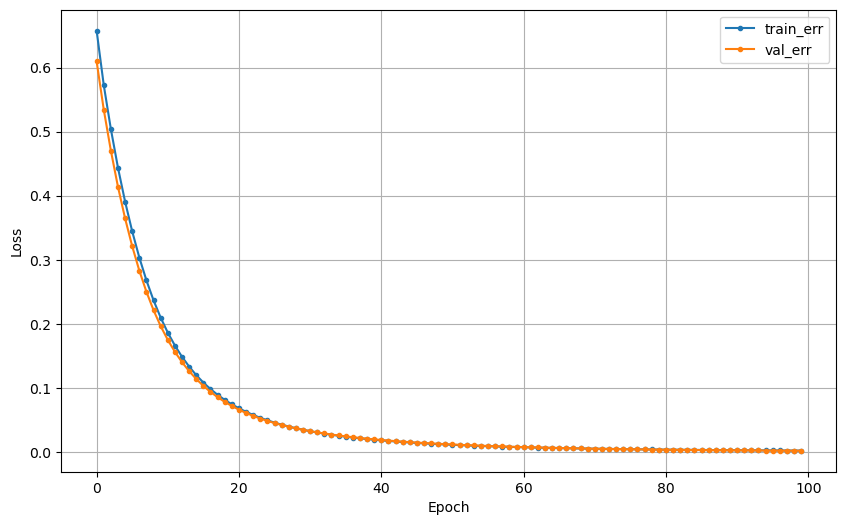

In [152]:
dl_history_plot(hist)

In [153]:
pred_dl = model_dl.predict(x_test_s)
pred_dl = np.where(pred_dl > .5, 1, 0)
print(confusion_matrix(y2_test, pred_dl))
print(classification_report(y2_test, pred_dl))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[968   1]
 [  0 796]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       969
           1       1.00      1.00      1.00       796

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



### 2.알고리즘

In [154]:
model_rf = RandomForestClassifier(max_depth=5, n_estimators=100)

In [155]:
model_rf.fit(x_train, y2_train)

RandomForestClassifier(max_depth=5)

In [156]:
pred_rf = model_rf.predict(x_test)
print(confusion_matrix(y2_test, pred_rf))
print(classification_report(y2_test, pred_rf))

[[968   1]
 [  0 796]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       969
           1       1.00      1.00      1.00       796

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [157]:
data_static = data.loc[data['Activity_dynamic'] == 0]
data_static.reset_index(drop=True, inplace=True)
data_static.head()

data_static_test = new_data.loc[new_data['Activity_dynamic'] == 0]
data_static_test.reset_index(drop=True, inplace=True)
data_static_test.head()

,tBodyAccJerk-entropy()-Y,tGravityAcc-energy()-Z,fBodyAccMag-entropy(),fBodyAccJerk-meanFreq()-Z,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,tGravityAccMag-mad(),fBodyAcc-entropy()-X,fBodyAccJerk-meanFreq()-X,fBodyAcc-std()-X,tBodyAccJerkMag-entropy(),"fBodyAccJerk-bandsEnergy()-1,16",tGravityAcc-energy()-X,fBodyAcc-meanFreq()-Z,fBodyAcc-max()-X,tBodyAccJerk-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,fBodyAccJerk-energy()-X,"fBodyAccJerk-bandsEnergy()-1,8",fBodyAccMag-mean(),"fBodyGyro-bandsEnergy()-17,32",Activity,fBodyAccJerk-mad()-X,fBodyAccMag-sma(),tBodyAccJerkMag-sma(),"tBodyAcc-correlation()-X,Y","fBodyAcc-bandsEnergy()-1,24",fBodyAccJerk-std()-X,tBodyAcc-energy()-X,tBodyAccJerk-mad()-X,"tGravityAcc-arCoeff()-Y,4",tBodyAccMag-std(),tGravityAcc-min()-Z,tGravityAcc-mean()-Y,"fBodyAcc-bandsEnergy()-17,24.2",fBodyAccJerk-meanFreq()-Y,Activity_dynamic,"angle(Y,gravityMean)","tGravityAcc-arCoeff()-Z,2",tGravityAcc-mean()-X,tBodyGyroJerk-mad()-Z,"tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,1",tBodyAccJerk-entropy()-X,tBodyAccJerk-sma(),fBodyGyro-maxInds-Z,tGravityAcc-min()-Y,"tGravityAcc-arCoeff()-Z,3","angle(Z,gravityMean)",tGravityAcc-max()-Z,fBodyAccJerk-kurtosis()-X,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Y,3","fBodyAcc-bandsEnergy()-1,8",fBodyBodyAccJerkMag-max(),fBodyAccMag-mad(),fBodyAcc-mean()-X,fBodyAccMag-energy(),tBodyAccJerk-std()-X,fBodyAccJerk-skewness()-X,tGravityAccMag-std(),"tGravityAcc-arCoeff()-Y,2","fBodyAccJerk-bandsEnergy()-1,24","tGravityAcc-arCoeff()-Z,4","angle(X,gravityMean)",fBodyAccJerk-maxInds-Z,fBodyAccJerk-kurtosis()-Y,tBodyGyroJerk-mad()-X,fBodyAcc-skewness()-X,tGravityAcc-max()-Y,fBodyAccJerk-maxInds-X,tBodyAccJerkMag-iqr(),fBodyAccJerk-mean()-X,tBodyGyroJerk-std()-X,tGravityAcc-energy()-Y,fBodyAccMag-std(),tBodyAcc-max()-X
0,-0.836903,-0.837166,-0.907014,-0.028030,0.284379,-0.543827,-0.980238,-0.946357,0.016977,-0.991842,-0.907576,-0.999980,0.723821,-0.245455,-0.990951,-0.999959,0.824267,0.914497,-0.999959,-0.999987,-0.986310,-0.999973,SITTING,-0.995234,-0.986310,-0.995098,-0.508076,-0.999938,-0.995613,-0.999931,-0.994998,0.657842,-0.980236,0.288453,0.148606,-0.999864,-0.012773,0,-0.018351,0.710376,0.895293,-0.996103,0.677876,-0.674893,-0.807351,-0.995234,-0.931034,0.168918,-0.710984,-0.185733,0.287013,-0.565531,-0.709284,-0.653694,-0.999927,-0.996361,-0.977702,-0.993627,-0.999605,-0.995504,-0.254906,-0.980236,0.658599,-0.999961,0.708158,-0.671943,-0.16,-0.919239,-0.997750,0.030028,0.120149,-0.20,-0.995844,-0.995724,-0.997618,-0.946390,-0.978766,-0.938850
1,-0.453018,-0.969423,-0.739177,-0.208813,0.277440,-0.122146,-0.965551,-1.000000,0.224041,-0.997250,-0.690332,-0.999979,0.894916,-0.234726,-0.998847,-0.999929,0.887625,0.981279,-0.999929,-0.999997,-0.966782,-0.999900,STANDING,-0.990875,-0.966782,-0.983811,-0.075354,-0.999981,-0.993240,-0.999980,-0.993766,0.514908,-0.957251,0.127359,-0.147634,-0.999728,-0.333748,0,0.184489,0.701373,0.961676,-0.994170,0.162417,-0.133592,-0.766910,-0.984241,-1.000000,-0.127980,-0.715078,-0.068699,0.124340,-0.845087,-0.687437,-0.506852,-0.999993,-0.984291,-0.954932,-0.995391,-0.998660,-0.993115,-0.476333,-0.957251,0.511910,-0.999932,0.725546,-0.826816,-0.12,-0.516223,-0.971783,-0.718557,-0.161674,-0.24,-0.985603,-0.993499,-0.969790,-0.967516,-0.957655,-0.939837
2,-0.803440,-0.922228,-0.873482,0.163180,0.276053,-0.646949,-0.988993,-0.946357,0.385911,-0.995583,-0.827107,-0.999982,0.652100,0.015603,-0.994600,-0.999936,0.795660,0.887126,-0.999936,-0.999992,-0.987735,-0.999975,SITTING,-0.991854,-0.987735,-0.991842,-0.456705,-0.999973,-0.993887,-0.999969,-0.993387,0.178599,-0.987743,0.202613,0.278727,-0.999929,0.119534,0,-0.111998,0.478310,0.866492,-0.997120,0.262081,-0.260774,-0.769828,-0.992071,-1.000000,0.298264,-0.481530,-0.123298,0.196111,-0.859596,-0.474742,-0.172626,-0.999973,-0.992395,-0.986673,-0.994777,-0.999801,-0.993617,-0.514998,-0.987743,0.188394,-0.999971,0.481837,-0.639435,-0.52,-0.960881,-0.995289,-0.144991,0.245302,0.12,-0.9

In [158]:
x_static = data_static.drop(['Activity', 'Activity_dynamic'], axis=1)
y_static = data_static['Activity'].map({'LAYING':0,
                                 'SITTING':1,
                                 'STANDING':2})


x_st = data_static_test.drop(['Activity', 'Activity_dynamic'], axis=1)
y_st = data_static_test['Activity'].map({'LAYING':0,
                                 'SITTING':1,
                                 'STANDING':2})

In [159]:
x_static_train, x_static_test, y_static_train, y_static_test = train_test_split(x_static, y_static, test_size=.3)
x_static_train = scaler.fit_transform(x_static_train)
x_static_test = scaler.transform(x_static_test)

x_ts = scaler.fit_transform(x_st)

In [170]:
model_dl_static = Sequential([Dense(50, input_shape=(nfeatures,), activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(16, activation='relu'),
                              Dense(3, activation='softmax')])
model_dl_static.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 50)                  │           3,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,061 (23.68 KB)

 Trainable params: 6,061 (23.68 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
model_dl_static.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

In [172]:
hist_static = model_dl_static.fit(x_static_train, y_static_train, epochs=149, validation_split=.2).history

Epoch 1/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9699 - val_loss: 0.6214
Epoch 2/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5057 - val_loss: 0.3535
Epoch 3/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3127 - val_loss: 0.3026
Epoch 4/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2499 - val_loss: 0.2590
Epoch 5/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2312 - val_loss: 0.2640
Epoch 6/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2029 - val_loss: 0.2238
Epoch 7/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1933 - val_loss: 0.2172
Epoch 8/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2059 - val_loss: 0.2735
Epoch 9/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2237 - val_loss: 0.1921
Epoch 10/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1877 - val_loss: 0.1864
Epoch 11/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1793 - val_loss: 0.1791
Epoch 12/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1

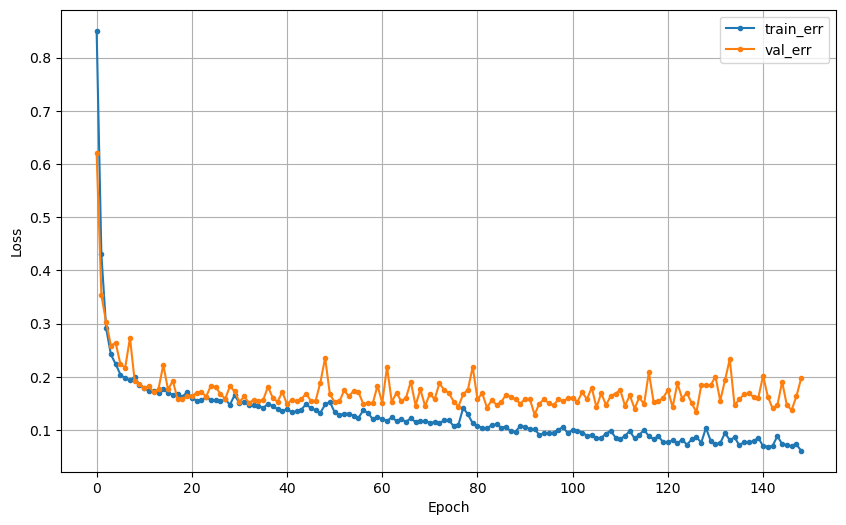

In [173]:
dl_history_plot(hist_static)

In [174]:
pred_dl_static = model_dl_static.predict(x_static_test)
pred_dl_static = pred_dl_static.argmax(axis=1)
print(confusion_matrix(y_static_test, pred_dl_static))
print(classification_report(y_static_test, pred_dl_static))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[348   1   0]
 [  1 270  47]
 [  0   9 295]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       349
           1       0.96      0.85      0.90       318
           2       0.86      0.97      0.91       304

    accuracy                           0.94       971
   macro avg       0.94      0.94      0.94       971
weighted avg       0.94      0.94      0.94       971



In [175]:
pred_dl_static_1 = model_dl_static.predict(x_ts)
pred_dl_static_1 = pred_dl_static_1.argmax(axis=1)
print(confusion_matrix(y_st, pred_dl_static_1))
print(classification_report(y_st, pred_dl_static_1))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[291   1   0]
 [  0 199  55]
 [  0  14 273]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.93      0.78      0.85       254
           2       0.83      0.95      0.89       287

    accuracy                           0.92       833
   macro avg       0.92      0.91      0.91       833
weighted avg       0.92      0.92      0.92       833



In [176]:
new_data.head()

,tBodyAccJerk-entropy()-Y,tGravityAcc-energy()-Z,fBodyAccMag-entropy(),fBodyAccJerk-meanFreq()-Z,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,tGravityAccMag-mad(),fBodyAcc-entropy()-X,fBodyAccJerk-meanFreq()-X,fBodyAcc-std()-X,tBodyAccJerkMag-entropy(),"fBodyAccJerk-bandsEnergy()-1,16",tGravityAcc-energy()-X,fBodyAcc-meanFreq()-Z,fBodyAcc-max()-X,tBodyAccJerk-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,fBodyAccJerk-energy()-X,"fBodyAccJerk-bandsEnergy()-1,8",fBodyAccMag-mean(),"fBodyGyro-bandsEnergy()-17,32",Activity,fBodyAccJerk-mad()-X,fBodyAccMag-sma(),tBodyAccJerkMag-sma(),"tBodyAcc-correlation()-X,Y","fBodyAcc-bandsEnergy()-1,24",fBodyAccJerk-std()-X,tBodyAcc-energy()-X,tBodyAccJerk-mad()-X,"tGravityAcc-arCoeff()-Y,4",tBodyAccMag-std(),tGravityAcc-min()-Z,tGravityAcc-mean()-Y,"fBodyAcc-bandsEnergy()-17,24.2",fBodyAccJerk-meanFreq()-Y,Activity_dynamic,"angle(Y,gravityMean)","tGravityAcc-arCoeff()-Z,2",tGravityAcc-mean()-X,tBodyGyroJerk-mad()-Z,"tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,1",tBodyAccJerk-entropy()-X,tBodyAccJerk-sma(),fBodyGyro-maxInds-Z,tGravityAcc-min()-Y,"tGravityAcc-arCoeff()-Z,3","angle(Z,gravityMean)",tGravityAcc-max()-Z,fBodyAccJerk-kurtosis()-X,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Y,3","fBodyAcc-bandsEnergy()-1,8",fBodyBodyAccJerkMag-max(),fBodyAccMag-mad(),fBodyAcc-mean()-X,fBodyAccMag-energy(),tBodyAccJerk-std()-X,fBodyAccJerk-skewness()-X,tGravityAccMag-std(),"tGravityAcc-arCoeff()-Y,2","fBodyAccJerk-bandsEnergy()-1,24","tGravityAcc-arCoeff()-Z,4","angle(X,gravityMean)",fBodyAccJerk-maxInds-Z,fBodyAccJerk-kurtosis()-Y,tBodyGyroJerk-mad()-X,fBodyAcc-skewness()-X,tGravityAcc-max()-Y,fBodyAccJerk-maxInds-X,tBodyAccJerkMag-iqr(),fBodyAccJerk-mean()-X,tBodyGyroJerk-std()-X,tGravityAcc-energy()-Y,fBodyAccMag-std(),tBodyAcc-max()-X
0,-0.836903,-0.837166,-0.907014,-0.028030,0.284379,-0.543827,-0.980238,-0.946357,0.016977,-0.991842,-0.907576,-0.999980,0.723821,-0.245455,-0.990951,-0.999959,0.824267,0.914497,-0.999959,-0.999987,-0.986310,-0.999973,SITTING,-0.995234,-0.986310,-0.995098,-0.508076,-0.999938,-0.995613,-0.999931,-0.994998,0.657842,-0.980236,0.288453,0.148606,-0.999864,-0.012773,0,-0.018351,0.710376,0.895293,-0.996103,0.677876,-0.674893,-0.807351,-0.995234,-0.931034,0.168918,-0.710984,-0.185733,0.287013,-0.565531,-0.709284,-0.653694,-0.999927,-0.996361,-0.977702,-0.993627,-0.999605,-0.995504,-0.254906,-0.980236,0.658599,-0.999961,0.708158,-0.671943,-0.16,-0.919239,-0.997750,0.030028,0.120149,-0.20,-0.995844,-0.995724,-0.997618,-0.946390,-0.978766,-0.938850
1,-0.453018,-0.969423,-0.739177,-0.208813,0.277440,-0.122146,-0.965551,-1.000000,0.224041,-0.997250,-0.690332,-0.999979,0.894916,-0.234726,-0.998847,-0.999929,0.887625,0.981279,-0.999929,-0.999997,-0.966782,-0.999900,STANDING,-0.990875,-0.966782,-0.983811,-0.075354,-0.999981,-0.993240,-0.999980,-0.993766,0.514908,-0.957251,0.127359,-0.147634,-0.999728,-0.333748,0,0.184489,0.701373,0.961676,-0.994170,0.162417,-0.133592,-0.766910,-0.984241,-1.000000,-0.127980,-0.715078,-0.068699,0.124340,-0.845087,-0.687437,-0.506852,-0.999993,-0.984291,-0.954932,-0.995391,-0.998660,-0.993115,-0.476333,-0.957251,0.511910,-0.999932,0.725546,-0.826816,-0.12,-0.516223,-0.971783,-0.718557,-0.161674,-0.24,-0.985603,-0.993499,-0.969790,-0.967516,-0.957655,-0.939837
2,0.640461,-0.994874,0.593725,-0.095902,0.305833,-0.185452,-0.270032,0.632759,-0.230025,0.066067,0.866725,-0.497834,0.835099,0.284468,0.013854,-0.422862,0.879426,0.942952,-0.421791,-0.564970,-0.077560,-0.525456,WALKING,0.268032,-0.077560,0.072032,-0.236772,-0.492487,0.158378,-0.492130,0.110156,-0.058458,-0.170002,-0.046761,-0.274905,-0.750940,-0.029718,1,0.272186,0.074048,0.938788,-0.269007,0.562824,-0.477563,0.862648,0.069913,-0.517241,-0.249192,-0.141032,0.053101,-0.049752,-0.555683,-0.002679,0.154730,-0.502167,0.338301,-0.146072,-0.161658,-0.650558,0.072216,0.016773,-0.170002,-0.221998,-0.445440,0.201304,-0.743234,-0.24,-0.757129,-0.222004,0.191594,-0.290636,-0.44,0.076722,-0.

### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [177]:
data_for_dynamic = data[['fBodyAccMag-std()', 'tGravityAcc-arCoeff()-X,2', 'tBodyAcc-energy()-X',
                         'fBodyAcc-max()-X', 'tBodyGyroJerk-std()-X', 'fBodyGyro-bandsEnergy()-17,32',
                         'fBodyGyro-bandsEnergy()-17,32', 'fBodyGyro-bandsEnergy()-17,32', 'tBodyGyroJerk-mad()-X',
                         'fBodyAcc-bandsEnergy()-1,24', 'tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,4',
                         'tGravityAcc-min()-Y', 'tGravityAcc-mean()-Y', 'tGravityAcc-arCoeff()-Z,3', 'fBodyGyro-maxInds-Z',
                         'tGravityAcc-energy()-Y', 'fBodyAccJerk-maxInds-Z', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Y,3',
                         'fBodyAccMag-mean()', 'tBodyAcc-max()-X', 'tGravityAccMag-std()', 'fBodyAccMag-energy()',
                         'fBodyAccMag-mad()', 'fBodyAcc-bandsEnergy()-1,8', 'fBodyAccMag-entropy()', 'tBodyAccMag-std()',
                         'tGravityAccMag-mad()', 'fBodyAccMag-sma()', 'Activity', 'Activity_dynamic']]

In [178]:
data_dynamic = data.loc[data['Activity_dynamic'] == 1]
data_dynamic.reset_index(drop=True, inplace=True)
data_dynamic.head()


data_dynamic_test = new_data.loc[new_data['Activity_dynamic'] == 1]
data_dynamic_test.reset_index(drop=True, inplace=True)
data_dynamic_test.head()


,tBodyAccJerk-entropy()-Y,tGravityAcc-energy()-Z,fBodyAccMag-entropy(),fBodyAccJerk-meanFreq()-Z,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,tGravityAccMag-mad(),fBodyAcc-entropy()-X,fBodyAccJerk-meanFreq()-X,fBodyAcc-std()-X,tBodyAccJerkMag-entropy(),"fBodyAccJerk-bandsEnergy()-1,16",tGravityAcc-energy()-X,fBodyAcc-meanFreq()-Z,fBodyAcc-max()-X,tBodyAccJerk-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,fBodyAccJerk-energy()-X,"fBodyAccJerk-bandsEnergy()-1,8",fBodyAccMag-mean(),"fBodyGyro-bandsEnergy()-17,32",Activity,fBodyAccJerk-mad()-X,fBodyAccMag-sma(),tBodyAccJerkMag-sma(),"tBodyAcc-correlation()-X,Y","fBodyAcc-bandsEnergy()-1,24",fBodyAccJerk-std()-X,tBodyAcc-energy()-X,tBodyAccJerk-mad()-X,"tGravityAcc-arCoeff()-Y,4",tBodyAccMag-std(),tGravityAcc-min()-Z,tGravityAcc-mean()-Y,"fBodyAcc-bandsEnergy()-17,24.2",fBodyAccJerk-meanFreq()-Y,Activity_dynamic,"angle(Y,gravityMean)","tGravityAcc-arCoeff()-Z,2",tGravityAcc-mean()-X,tBodyGyroJerk-mad()-Z,"tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,1",tBodyAccJerk-entropy()-X,tBodyAccJerk-sma(),fBodyGyro-maxInds-Z,tGravityAcc-min()-Y,"tGravityAcc-arCoeff()-Z,3","angle(Z,gravityMean)",tGravityAcc-max()-Z,fBodyAccJerk-kurtosis()-X,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Y,3","fBodyAcc-bandsEnergy()-1,8",fBodyBodyAccJerkMag-max(),fBodyAccMag-mad(),fBodyAcc-mean()-X,fBodyAccMag-energy(),tBodyAccJerk-std()-X,fBodyAccJerk-skewness()-X,tGravityAccMag-std(),"tGravityAcc-arCoeff()-Y,2","fBodyAccJerk-bandsEnergy()-1,24","tGravityAcc-arCoeff()-Z,4","angle(X,gravityMean)",fBodyAccJerk-maxInds-Z,fBodyAccJerk-kurtosis()-Y,tBodyGyroJerk-mad()-X,fBodyAcc-skewness()-X,tGravityAcc-max()-Y,fBodyAccJerk-maxInds-X,tBodyAccJerkMag-iqr(),fBodyAccJerk-mean()-X,tBodyGyroJerk-std()-X,tGravityAcc-energy()-Y,fBodyAccMag-std(),tBodyAcc-max()-X
0,0.640461,-0.994874,0.593725,-0.095902,0.305833,-0.185452,-0.270032,0.632759,-0.230025,0.066067,0.866725,-0.497834,0.835099,0.284468,0.013854,-0.422862,0.879426,0.942952,-0.421791,-0.564970,-0.077560,-0.525456,WALKING,0.268032,-0.077560,0.072032,-0.236772,-0.492487,0.158378,-0.492130,0.110156,-0.058458,-0.170002,-0.046761,-0.274905,-0.750940,-0.029718,1,0.272186,0.074048,0.938788,-0.269007,0.562824,-0.477563,0.862648,0.069913,-0.517241,-0.249192,-0.141032,0.053101,-0.049752,-0.555683,-0.002679,0.154730,-0.502167,0.338301,-0.146072,-0.161658,-0.650558,0.072216,0.016773,-0.170002,-0.221998,-0.445440,0.201304,-0.743234,-0.24,-0.757129,-0.222004,0.191594,-0.290636,-0.44,0.076722,-0.114291,-0.207693,-0.872740,-0.355980,0.016311
1,0.549612,-0.930613,0.528133,-0.254604,0.336801,-0.002440,-0.420263,0.512066,-0.124275,-0.431266,0.772687,-0.854015,0.822247,0.087941,-0.483214,-0.753675,0.874542,0.945389,-0.753234,-0.913680,-0.205818,-0.813534,WALKING,-0.205562,-0.205818,-0.187816,-0.239297,-0.837713,-0.286425,-0.838911,-0.264829,0.116173,-0.263446,-0.190434,-0.150843,-0.716404,-0.354461,1,0.187548,0.266719,0.933849,-0.454879,0.490251,-0.428314,0.542300,-0.153468,-0.655172,-0.133001,-0.369181,0.149686,-0.165832,-0.348921,-0.164478,-0.024785,-0.864305,-0.032917,-0.328054,-0.447870,-0.724020,-0.301917,0.133845,-0.263446,-0.040011,-0.728837,0.469098,-0.775712,-0.40,-0.512649,-0.417873,0.022449,-0.160837,-0.32,-0.241454,-0.377223,-0.403998,-0.965847,-0.412349,-0.288437
2,0.511410,-0.998487,0.436443,-0.578513,0.087902,-0.494418,-0.374186,0.320004,-0.306462,-0.167338,0.571839,-0.851458,0.930446,-0.698121,-0.128764,-0.865053,0.929182,0.953440,-0.864861,-0.805677,-0.320208,-0.971167,WALKING_UPSTAIRS,-0.476250,-0.320208,-0.533393,-0.210221,-0.684386,-0.520336,-0.685610,-0.467355,0.729723,-0.234554,-0.010085,-0.150270,-0.984396,-0.556941,1,0.186079,0.856106,0.974910,-0.569561,0.849807,-0.817872,0.479460,-0.530163,-0.793103,-0.192798,-0.869631,0.007999,0.049895,-0.174998,-0.842038,-0.709713,-0.618638,-0.574296,-0.159581,-0.363119,-0.702252,-0.485182,0.180221,-0.234554,0.697930,-0.852772,0.879389,-0.872144,-0.96,-0.922690,-0.710263,0.480456,-0.130216,-0.88,-0.587142,-0.4

In [179]:
x_dynamic = data_dynamic.drop(['Activity', 'Activity_dynamic'], axis=1)
y_dynamic = data_dynamic['Activity'].map({'WALKING':0,
                                 'WALKING_UPSTAIRS':1,
                                 'WALKING_DOWNSTAIRS':2})

x_d = data_dynamic_test.drop(['Activity', 'Activity_dynamic'], axis=1)
y_d = data_dynamic_test['Activity'].map({'WALKING':0,
                                 'WALKING_UPSTAIRS':1,
                                 'WALKING_DOWNSTAIRS':2})

In [180]:
x_dynamic.shape, y_dynamic.shape

((2647, 76), (2647,))

In [181]:
x_dynamic_train, x_dynamic_test, y_dynamic_train, y_dynamic_test = train_test_split(x_dynamic, y_dynamic, test_size=.3)
x_dynamic_train = scaler.fit_transform(x_dynamic_train)
x_dynamic_test = scaler.transform(x_dynamic_test)
x_dt = scaler.fit_transform(x_d)

In [185]:
clear_session()
model_dl_dynamic = Sequential([Dense(8, input_shape=(x_dynamic_train.shape[1],), activation='relu'),
                              #  Dense(6, activation='relu'),
                              Dense(3, activation='softmax')])
model_dl_dynamic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643 (2.51 KB)

 Trainable params: 643 (2.51 KB)

 Non-trainable params: 0 (0.00 B)

In [186]:
model_dl_dynamic.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy')

In [187]:
hist_dynamic = model_dl_dynamic.fit(x_dynamic_train, y_dynamic_train, epochs=200, validation_split=.2).history

Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0856 - val_loss: 1.0158
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9935 - val_loss: 0.9279
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9101 - val_loss: 0.8650
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8445 - val_loss: 0.8071
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7855 - val_loss: 0.7488
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7430 - val_loss: 0.6943
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - val_loss: 0.6392
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6393 - val_loss: 0.5890
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5861 - val_loss: 0.5430
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5370 - val_loss: 0.5021
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5115 - val_loss: 0.4697
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4

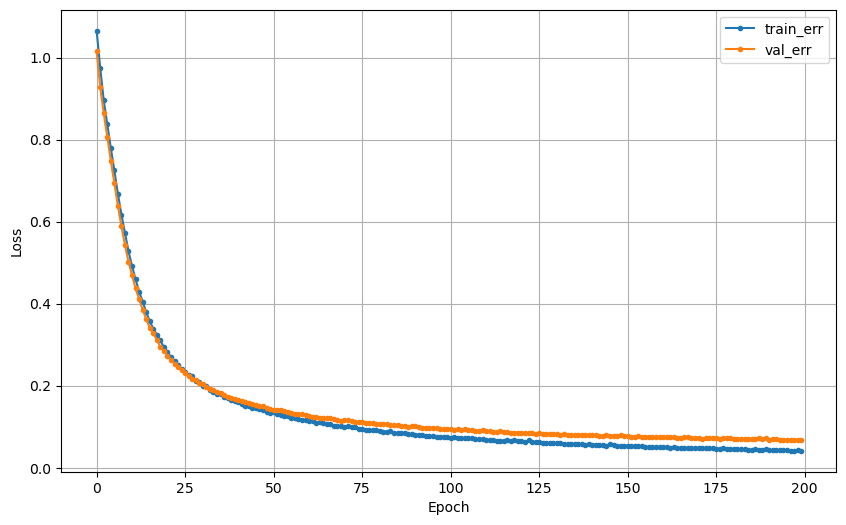

In [188]:
dl_history_plot(hist_dynamic)

In [189]:
pred_dl_dynamic = model_dl_dynamic.predict(x_dynamic_test)
pred_dl_dynamic = pred_dl_dynamic.argmax(axis=1)
print(confusion_matrix(y_dynamic_test, pred_dl_dynamic))
print(classification_report(y_dynamic_test, pred_dl_dynamic))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[294   5   1]
 [  6 260   0]
 [  3   1 225]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.98      0.98      0.98       266
           2       1.00      0.98      0.99       229

    accuracy                           0.98       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.98      0.98      0.98       795



pred_Dl = model_dl_dynamic.predict(x_dt)
pred_Dl = pred_Dl.argmax(axis=1)
print(confusion_matrix(y_d, pred_Dl))
print(classification_report(y_d, pred_Dl))

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Input, Dense, concatenate
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [134]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [135]:
data = pd.read_csv('data01_train.csv')
data.drop('subject', axis=1, inplace=True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [136]:
data = data.dropna()

In [137]:
new_data = pd.read_csv('data01_test.csv')
new_data.drop('subject', axis=1, inplace=True)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [138]:
new_data = new_data.dropna()

In [139]:
data_backup = data.copy()
new_data_backup = new_data.copy()

In [140]:
data = data_backup.copy()
new_data = new_data_backup.copy()

In [141]:
list1 = ['tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,4', 'tGravityAcc-min()-Y', 'tGravityAcc-mean()-Y',
            'tGravityAcc-arCoeff()-Z,3', 'fBodyGyro-maxInds-Z', 'tGravityAcc-energy()-Y',
            'fBodyAccJerk-maxInds-Z', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Y,3',
            'tBodyAcc-max()-X', 'angle(Y,gravityMean)', 'tGravityAcc-max()-Y', 'fBodyAcc-max()-X',
            'fBodyAccMag-std()', 'fBodyAccJerk-bandsEnergy()-1,8', 'fBodyAcc-bandsEnergy()-1,8',
            'fBodyAcc-bandsEnergy()-1,24', 'tBodyAccJerkMag-iqr()', 'angle(X,gravityMean)', 'tBodyAcc-energy()-X',
            'tGravityAcc-energy()-X', 'fBodyAccMag-mad()', 'tGravityAcc-max()-Z', 'tGravityAcc-mean()-X',
            'fBodyAccMag-sma()', 'fBodyAccJerk-mean()-X', 'fBodyAccMag-energy()', 'tGravityAcc-max()-X',
            'tBodyAccJerk-sma()', 'tBodyAccJerkMag-entropy()', 'tBodyAccJerk-mad()-X', 'angle(Z,gravityMean)',
            'fBodyAcc-mean()-X', 'tBodyAccMag-std()', 'tBodyAccJerkMag-sma()', 'tGravityAcc-min()-X',
            'tGravityAcc-arCoeff()-X,2', 'tBodyGyroJerk-mad()-Z', 'tGravityAcc-min()-Z', 'tGravityAccMag-mad()',
            'fBodyAccMag-mean()', 'tGravityAccMag-std()', 'fBodyAccMag-entropy()', 'fBodyAcc-entropy()-X',
            'fBodyAcc-skewness()-X', 'tBodyGyroJerk-mad()-X', 'fBodyGyro-bandsEnergy()-17,32',
            'fBodyGyro-bandsEnergy()-17,32', 'fBodyGyro-bandsEnergy()-17,32', 'tBodyGyroJerk-std()-X', 'Activity']

list2 = ['angle(X,gravityMean)','tGravityAcc-min()-X','tGravityAcc-energy()-X',
'tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-max()-Y',
'tGravityAcc-min()-Y','tGravityAcc-max()-X','angle(Y,gravityMean)',
'tBodyAccJerk-energy()-X','fBodyAccJerk-mad()-X','tBodyAccJerk-mad()-X',
'fBodyAccJerk-bandsEnergy()-1,24','fBodyAccJerk-bandsEnergy()-1,16','tBodyAccJerk-std()-X',
'fBodyAccJerk-energy()-X','fBodyAccJerk-std()-X','tBodyAccJerk-entropy()-Y',
'tBodyAccJerk-entropy()-X','tGravityAcc-max()-Z','angle(Z,gravityMean)',
'tGravityAcc-min()-Z','tGravityAcc-energy()-Z','tGravityAcc-arCoeff()-X,1',
'fBodyAcc-bandsEnergy()-17,24.2','fBodyAccMag-std()','tBodyAcc-correlation()-X,Y',
'fBodyAcc-max()-X','tBodyGyroJerk-mad()-X','tGravityAccMag-mad()',
'fBodyBodyAccJerkMag-max()','fBodyAcc-std()-X','tGravityAcc-arCoeff()-Z,1',
'tGravityAcc-arCoeff()-Z,4','tGravityAcc-arCoeff()-Z,3','tGravityAcc-energy()-Y',
'tGravityAcc-arCoeff()-Y,2','fBodyGyro-maxInds-Z','tGravityAcc-arCoeff()-Y,4',
'fBodyAcc-meanFreq()-Z','tBodyAcc-mean()-X','fBodyAccJerk-skewness()-Y',
'fBodyAccJerk-maxInds-Z','fBodyAccJerk-meanFreq()-X','fBodyAccJerk-meanFreq()-Y',
'fBodyAccJerk-meanFreq()-Z','fBodyAccJerk-skewness()-X','fBodyAccJerk-kurtosis()-X',
'fBodyAccJerk-kurtosis()-Y','fBodyAccJerk-maxInds-X','Activity','Activity_dynamic']

tmp = list(set(list1 + list2))
tmp

['tBodyAccJerk-entropy()-Y',
 'tGravityAcc-energy()-Z',
 'fBodyAccMag-entropy()',
 'fBodyAccJerk-meanFreq()-Z',
 'tBodyAcc-mean()-X',
 'fBodyAccJerk-skewness()-Y',
 'tGravityAccMag-mad()',
 'fBodyAcc-entropy()-X',
 'fBodyAccJerk-meanFreq()-X',
 'fBodyAcc-std()-X',
 'tBodyAccJerkMag-entropy()',
 'fBodyAccJerk-bandsEnergy()-1,16',
 'tGravityAcc-energy()-X',
 'fBodyAcc-meanFreq()-Z',
 'fBodyAcc-max()-X',
 'tBodyAccJerk-energy()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-min()-X',
 'fBodyAccJerk-energy()-X',
 'fBodyAccJerk-bandsEnergy()-1,8',
 'fBodyAccMag-mean()',
 'fBodyGyro-bandsEnergy()-17,32',
 'Activity',
 'fBodyAccJerk-mad()-X',
 'fBodyAccMag-sma()',
 'tBodyAccJerkMag-sma()',
 'tBodyAcc-correlation()-X,Y',
 'fBodyAcc-bandsEnergy()-1,24',
 'fBodyAccJerk-std()-X',
 'tBodyAcc-energy()-X',
 'tBodyAccJerk-mad()-X',
 'tGravityAcc-arCoeff()-Y,4',
 'tBodyAccMag-std()',
 'tGravityAcc-min()-Z',
 'tGravityAcc-mean()-Y',
 'fBodyAcc-bandsEnergy()-17,24.2',
 'fBodyAccJerk-meanFreq()-Y',
 'Activity

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [143]:
dynamic_vals = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data['Activity_dynamic'] = np.where(data['Activity'].isin(dynamic_vals), 1, 0)
data.head()

new_data['Activity_dynamic'] = np.where(new_data['Activity'].isin(dynamic_vals), 1, 0)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [192]:
data = data[tmp]
new_data = new_data[tmp]
print(data.shape)
print(new_data.shape)

(5881, 78)
(1471, 78)


In [146]:
target_y1 = 'Activity'
target_y2 = 'Activity_dynamic'
x = data.drop([target_y1, target_y2], axis=1)
y1 = data.loc[:, target_y1]
y2 = data.loc[:, target_y2]

In [147]:
x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size=.3)
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size=.3)
print(x_train.shape, x_test.shape)
print(y1_train.shape, y1_test.shape)
print(y2_train.shape, y2_test.shape)

(4116, 76) (1765, 76)
(4116,) (1765,)
(4116,) (1765,)


## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

In [148]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 : DeepLearning

In [149]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

In [150]:
nfeatures = x_train_s.shape[1]

model_dl = Sequential([Dense(8, input_shape=(nfeatures,), activation='relu'),
                    Dense(1, activation='sigmoid')])

model_dl.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 8)                   │             616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 625 (2.44 KB)

 Trainable params: 625 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
model_dl.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
hist = model_dl.fit(x_train_s, y2_train, epochs=100, validation_split=.2).history

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6806 - val_loss: 0.6096
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5916 - val_loss: 0.5345
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5174 - val_loss: 0.4703
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4568 - val_loss: 0.4138
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4023 - val_loss: 0.3645
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3537 - val_loss: 0.3210
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3141 - val_loss: 0.2829
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2751 - val_loss: 0.2499
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2445 - val_loss: 0.2212
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2155 - val_loss: 0.1963
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1906 - val_loss: 0.1748
Epoch 12/100
103/103 ━━━━━━━━━━━━━━━━━━━━

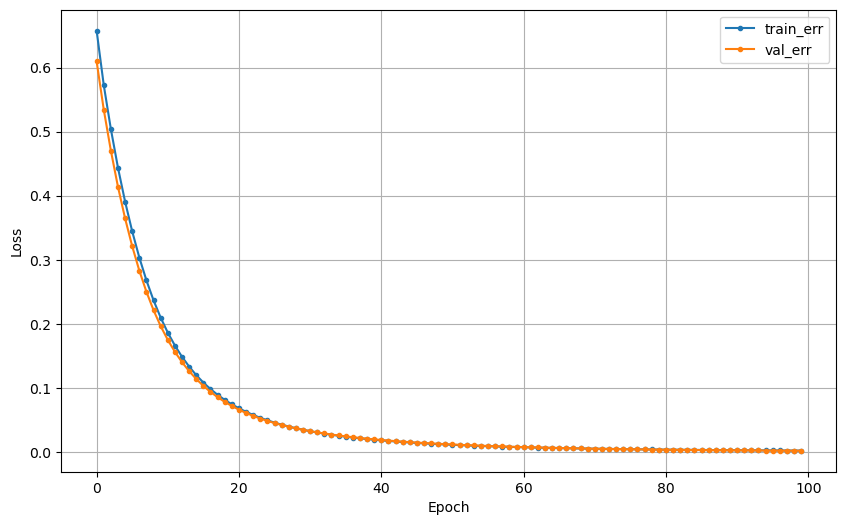

In [152]:
dl_history_plot(hist)

In [153]:
pred_dl = model_dl.predict(x_test_s)
pred_dl = np.where(pred_dl > .5, 1, 0)
print(confusion_matrix(y2_test, pred_dl))
print(classification_report(y2_test, pred_dl))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[968   1]
 [  0 796]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       969
           1       1.00      1.00      1.00       796

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



### 2.알고리즘

In [154]:
model_rf = RandomForestClassifier(max_depth=5, n_estimators=100)

In [155]:
model_rf.fit(x_train, y2_train)

RandomForestClassifier(max_depth=5)

In [156]:
pred_rf = model_rf.predict(x_test)
print(confusion_matrix(y2_test, pred_rf))
print(classification_report(y2_test, pred_rf))

[[968   1]
 [  0 796]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       969
           1       1.00      1.00      1.00       796

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [157]:
data_static = data.loc[data['Activity_dynamic'] == 0]
data_static.reset_index(drop=True, inplace=True)
data_static.head()

data_static_test = new_data.loc[new_data['Activity_dynamic'] == 0]
data_static_test.reset_index(drop=True, inplace=True)
data_static_test.head()

,tBodyAccJerk-entropy()-Y,tGravityAcc-energy()-Z,fBodyAccMag-entropy(),fBodyAccJerk-meanFreq()-Z,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,tGravityAccMag-mad(),fBodyAcc-entropy()-X,fBodyAccJerk-meanFreq()-X,fBodyAcc-std()-X,tBodyAccJerkMag-entropy(),"fBodyAccJerk-bandsEnergy()-1,16",tGravityAcc-energy()-X,fBodyAcc-meanFreq()-Z,fBodyAcc-max()-X,tBodyAccJerk-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,fBodyAccJerk-energy()-X,"fBodyAccJerk-bandsEnergy()-1,8",fBodyAccMag-mean(),"fBodyGyro-bandsEnergy()-17,32",Activity,fBodyAccJerk-mad()-X,fBodyAccMag-sma(),tBodyAccJerkMag-sma(),"tBodyAcc-correlation()-X,Y","fBodyAcc-bandsEnergy()-1,24",fBodyAccJerk-std()-X,tBodyAcc-energy()-X,tBodyAccJerk-mad()-X,"tGravityAcc-arCoeff()-Y,4",tBodyAccMag-std(),tGravityAcc-min()-Z,tGravityAcc-mean()-Y,"fBodyAcc-bandsEnergy()-17,24.2",fBodyAccJerk-meanFreq()-Y,Activity_dynamic,"angle(Y,gravityMean)","tGravityAcc-arCoeff()-Z,2",tGravityAcc-mean()-X,tBodyGyroJerk-mad()-Z,"tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,1",tBodyAccJerk-entropy()-X,tBodyAccJerk-sma(),fBodyGyro-maxInds-Z,tGravityAcc-min()-Y,"tGravityAcc-arCoeff()-Z,3","angle(Z,gravityMean)",tGravityAcc-max()-Z,fBodyAccJerk-kurtosis()-X,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Y,3","fBodyAcc-bandsEnergy()-1,8",fBodyBodyAccJerkMag-max(),fBodyAccMag-mad(),fBodyAcc-mean()-X,fBodyAccMag-energy(),tBodyAccJerk-std()-X,fBodyAccJerk-skewness()-X,tGravityAccMag-std(),"tGravityAcc-arCoeff()-Y,2","fBodyAccJerk-bandsEnergy()-1,24","tGravityAcc-arCoeff()-Z,4","angle(X,gravityMean)",fBodyAccJerk-maxInds-Z,fBodyAccJerk-kurtosis()-Y,tBodyGyroJerk-mad()-X,fBodyAcc-skewness()-X,tGravityAcc-max()-Y,fBodyAccJerk-maxInds-X,tBodyAccJerkMag-iqr(),fBodyAccJerk-mean()-X,tBodyGyroJerk-std()-X,tGravityAcc-energy()-Y,fBodyAccMag-std(),tBodyAcc-max()-X
0,-0.836903,-0.837166,-0.907014,-0.028030,0.284379,-0.543827,-0.980238,-0.946357,0.016977,-0.991842,-0.907576,-0.999980,0.723821,-0.245455,-0.990951,-0.999959,0.824267,0.914497,-0.999959,-0.999987,-0.986310,-0.999973,SITTING,-0.995234,-0.986310,-0.995098,-0.508076,-0.999938,-0.995613,-0.999931,-0.994998,0.657842,-0.980236,0.288453,0.148606,-0.999864,-0.012773,0,-0.018351,0.710376,0.895293,-0.996103,0.677876,-0.674893,-0.807351,-0.995234,-0.931034,0.168918,-0.710984,-0.185733,0.287013,-0.565531,-0.709284,-0.653694,-0.999927,-0.996361,-0.977702,-0.993627,-0.999605,-0.995504,-0.254906,-0.980236,0.658599,-0.999961,0.708158,-0.671943,-0.16,-0.919239,-0.997750,0.030028,0.120149,-0.20,-0.995844,-0.995724,-0.997618,-0.946390,-0.978766,-0.938850
1,-0.453018,-0.969423,-0.739177,-0.208813,0.277440,-0.122146,-0.965551,-1.000000,0.224041,-0.997250,-0.690332,-0.999979,0.894916,-0.234726,-0.998847,-0.999929,0.887625,0.981279,-0.999929,-0.999997,-0.966782,-0.999900,STANDING,-0.990875,-0.966782,-0.983811,-0.075354,-0.999981,-0.993240,-0.999980,-0.993766,0.514908,-0.957251,0.127359,-0.147634,-0.999728,-0.333748,0,0.184489,0.701373,0.961676,-0.994170,0.162417,-0.133592,-0.766910,-0.984241,-1.000000,-0.127980,-0.715078,-0.068699,0.124340,-0.845087,-0.687437,-0.506852,-0.999993,-0.984291,-0.954932,-0.995391,-0.998660,-0.993115,-0.476333,-0.957251,0.511910,-0.999932,0.725546,-0.826816,-0.12,-0.516223,-0.971783,-0.718557,-0.161674,-0.24,-0.985603,-0.993499,-0.969790,-0.967516,-0.957655,-0.939837
2,-0.803440,-0.922228,-0.873482,0.163180,0.276053,-0.646949,-0.988993,-0.946357,0.385911,-0.995583,-0.827107,-0.999982,0.652100,0.015603,-0.994600,-0.999936,0.795660,0.887126,-0.999936,-0.999992,-0.987735,-0.999975,SITTING,-0.991854,-0.987735,-0.991842,-0.456705,-0.999973,-0.993887,-0.999969,-0.993387,0.178599,-0.987743,0.202613,0.278727,-0.999929,0.119534,0,-0.111998,0.478310,0.866492,-0.997120,0.262081,-0.260774,-0.769828,-0.992071,-1.000000,0.298264,-0.481530,-0.123298,0.196111,-0.859596,-0.474742,-0.172626,-0.999973,-0.992395,-0.986673,-0.994777,-0.999801,-0.993617,-0.514998,-0.987743,0.188394,-0.999971,0.481837,-0.639435,-0.52,-0.960881,-0.995289,-0.144991,0.245302,0.12,-0.9

In [158]:
x_static = data_static.drop(['Activity', 'Activity_dynamic'], axis=1)
y_static = data_static['Activity'].map({'LAYING':0,
                                 'SITTING':1,
                                 'STANDING':2})


x_st = data_static_test.drop(['Activity', 'Activity_dynamic'], axis=1)
y_st = data_static_test['Activity'].map({'LAYING':0,
                                 'SITTING':1,
                                 'STANDING':2})

In [159]:
x_static_train, x_static_test, y_static_train, y_static_test = train_test_split(x_static, y_static, test_size=.3)
x_static_train = scaler.fit_transform(x_static_train)
x_static_test = scaler.transform(x_static_test)

x_ts = scaler.fit_transform(x_st)

In [170]:
model_dl_static = Sequential([Dense(50, input_shape=(nfeatures,), activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(16, activation='relu'),
                              Dense(3, activation='softmax')])
model_dl_static.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 50)                  │           3,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,061 (23.68 KB)

 Trainable params: 6,061 (23.68 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
model_dl_static.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

In [172]:
hist_static = model_dl_static.fit(x_static_train, y_static_train, epochs=149, validation_split=.2).history

Epoch 1/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9699 - val_loss: 0.6214
Epoch 2/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5057 - val_loss: 0.3535
Epoch 3/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3127 - val_loss: 0.3026
Epoch 4/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2499 - val_loss: 0.2590
Epoch 5/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2312 - val_loss: 0.2640
Epoch 6/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2029 - val_loss: 0.2238
Epoch 7/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1933 - val_loss: 0.2172
Epoch 8/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2059 - val_loss: 0.2735
Epoch 9/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2237 - val_loss: 0.1921
Epoch 10/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1877 - val_loss: 0.1864
Epoch 11/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1793 - val_loss: 0.1791
Epoch 12/149
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1

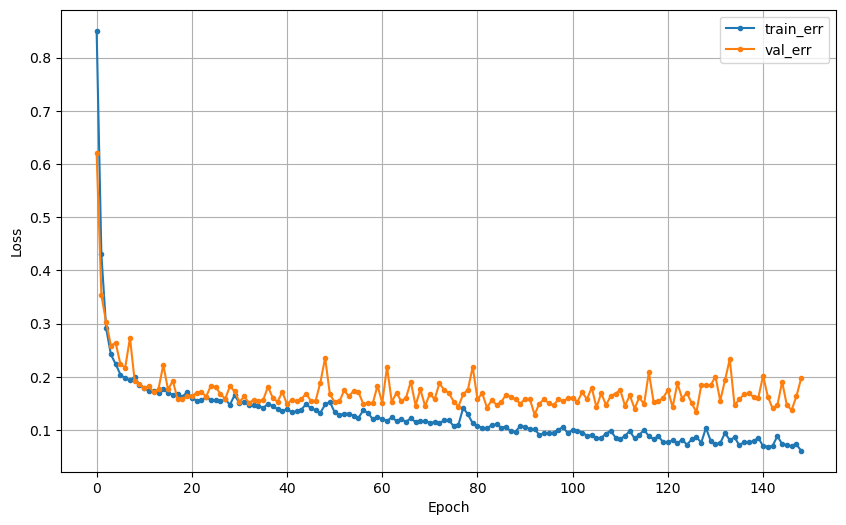

In [173]:
dl_history_plot(hist_static)

In [174]:
pred_dl_static = model_dl_static.predict(x_static_test)
pred_dl_static = pred_dl_static.argmax(axis=1)
print(confusion_matrix(y_static_test, pred_dl_static))
print(classification_report(y_static_test, pred_dl_static))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[348   1   0]
 [  1 270  47]
 [  0   9 295]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       349
           1       0.96      0.85      0.90       318
           2       0.86      0.97      0.91       304

    accuracy                           0.94       971
   macro avg       0.94      0.94      0.94       971
weighted avg       0.94      0.94      0.94       971



In [175]:
pred_dl_static_1 = model_dl_static.predict(x_ts)
pred_dl_static_1 = pred_dl_static_1.argmax(axis=1)
print(confusion_matrix(y_st, pred_dl_static_1))
print(classification_report(y_st, pred_dl_static_1))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[291   1   0]
 [  0 199  55]
 [  0  14 273]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.93      0.78      0.85       254
           2       0.83      0.95      0.89       287

    accuracy                           0.92       833
   macro avg       0.92      0.91      0.91       833
weighted avg       0.92      0.92      0.92       833



In [176]:
new_data.head()

,tBodyAccJerk-entropy()-Y,tGravityAcc-energy()-Z,fBodyAccMag-entropy(),fBodyAccJerk-meanFreq()-Z,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,tGravityAccMag-mad(),fBodyAcc-entropy()-X,fBodyAccJerk-meanFreq()-X,fBodyAcc-std()-X,tBodyAccJerkMag-entropy(),"fBodyAccJerk-bandsEnergy()-1,16",tGravityAcc-energy()-X,fBodyAcc-meanFreq()-Z,fBodyAcc-max()-X,tBodyAccJerk-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,fBodyAccJerk-energy()-X,"fBodyAccJerk-bandsEnergy()-1,8",fBodyAccMag-mean(),"fBodyGyro-bandsEnergy()-17,32",Activity,fBodyAccJerk-mad()-X,fBodyAccMag-sma(),tBodyAccJerkMag-sma(),"tBodyAcc-correlation()-X,Y","fBodyAcc-bandsEnergy()-1,24",fBodyAccJerk-std()-X,tBodyAcc-energy()-X,tBodyAccJerk-mad()-X,"tGravityAcc-arCoeff()-Y,4",tBodyAccMag-std(),tGravityAcc-min()-Z,tGravityAcc-mean()-Y,"fBodyAcc-bandsEnergy()-17,24.2",fBodyAccJerk-meanFreq()-Y,Activity_dynamic,"angle(Y,gravityMean)","tGravityAcc-arCoeff()-Z,2",tGravityAcc-mean()-X,tBodyGyroJerk-mad()-Z,"tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,1",tBodyAccJerk-entropy()-X,tBodyAccJerk-sma(),fBodyGyro-maxInds-Z,tGravityAcc-min()-Y,"tGravityAcc-arCoeff()-Z,3","angle(Z,gravityMean)",tGravityAcc-max()-Z,fBodyAccJerk-kurtosis()-X,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Y,3","fBodyAcc-bandsEnergy()-1,8",fBodyBodyAccJerkMag-max(),fBodyAccMag-mad(),fBodyAcc-mean()-X,fBodyAccMag-energy(),tBodyAccJerk-std()-X,fBodyAccJerk-skewness()-X,tGravityAccMag-std(),"tGravityAcc-arCoeff()-Y,2","fBodyAccJerk-bandsEnergy()-1,24","tGravityAcc-arCoeff()-Z,4","angle(X,gravityMean)",fBodyAccJerk-maxInds-Z,fBodyAccJerk-kurtosis()-Y,tBodyGyroJerk-mad()-X,fBodyAcc-skewness()-X,tGravityAcc-max()-Y,fBodyAccJerk-maxInds-X,tBodyAccJerkMag-iqr(),fBodyAccJerk-mean()-X,tBodyGyroJerk-std()-X,tGravityAcc-energy()-Y,fBodyAccMag-std(),tBodyAcc-max()-X
0,-0.836903,-0.837166,-0.907014,-0.028030,0.284379,-0.543827,-0.980238,-0.946357,0.016977,-0.991842,-0.907576,-0.999980,0.723821,-0.245455,-0.990951,-0.999959,0.824267,0.914497,-0.999959,-0.999987,-0.986310,-0.999973,SITTING,-0.995234,-0.986310,-0.995098,-0.508076,-0.999938,-0.995613,-0.999931,-0.994998,0.657842,-0.980236,0.288453,0.148606,-0.999864,-0.012773,0,-0.018351,0.710376,0.895293,-0.996103,0.677876,-0.674893,-0.807351,-0.995234,-0.931034,0.168918,-0.710984,-0.185733,0.287013,-0.565531,-0.709284,-0.653694,-0.999927,-0.996361,-0.977702,-0.993627,-0.999605,-0.995504,-0.254906,-0.980236,0.658599,-0.999961,0.708158,-0.671943,-0.16,-0.919239,-0.997750,0.030028,0.120149,-0.20,-0.995844,-0.995724,-0.997618,-0.946390,-0.978766,-0.938850
1,-0.453018,-0.969423,-0.739177,-0.208813,0.277440,-0.122146,-0.965551,-1.000000,0.224041,-0.997250,-0.690332,-0.999979,0.894916,-0.234726,-0.998847,-0.999929,0.887625,0.981279,-0.999929,-0.999997,-0.966782,-0.999900,STANDING,-0.990875,-0.966782,-0.983811,-0.075354,-0.999981,-0.993240,-0.999980,-0.993766,0.514908,-0.957251,0.127359,-0.147634,-0.999728,-0.333748,0,0.184489,0.701373,0.961676,-0.994170,0.162417,-0.133592,-0.766910,-0.984241,-1.000000,-0.127980,-0.715078,-0.068699,0.124340,-0.845087,-0.687437,-0.506852,-0.999993,-0.984291,-0.954932,-0.995391,-0.998660,-0.993115,-0.476333,-0.957251,0.511910,-0.999932,0.725546,-0.826816,-0.12,-0.516223,-0.971783,-0.718557,-0.161674,-0.24,-0.985603,-0.993499,-0.969790,-0.967516,-0.957655,-0.939837
2,0.640461,-0.994874,0.593725,-0.095902,0.305833,-0.185452,-0.270032,0.632759,-0.230025,0.066067,0.866725,-0.497834,0.835099,0.284468,0.013854,-0.422862,0.879426,0.942952,-0.421791,-0.564970,-0.077560,-0.525456,WALKING,0.268032,-0.077560,0.072032,-0.236772,-0.492487,0.158378,-0.492130,0.110156,-0.058458,-0.170002,-0.046761,-0.274905,-0.750940,-0.029718,1,0.272186,0.074048,0.938788,-0.269007,0.562824,-0.477563,0.862648,0.069913,-0.517241,-0.249192,-0.141032,0.053101,-0.049752,-0.555683,-0.002679,0.154730,-0.502167,0.338301,-0.146072,-0.161658,-0.650558,0.072216,0.016773,-0.170002,-0.221998,-0.445440,0.201304,-0.743234,-0.24,-0.757129,-0.222004,0.191594,-0.290636,-0.44,0.076722,-0.

### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [177]:
data_for_dynamic = data[['fBodyAccMag-std()', 'tGravityAcc-arCoeff()-X,2', 'tBodyAcc-energy()-X',
                         'fBodyAcc-max()-X', 'tBodyGyroJerk-std()-X', 'fBodyGyro-bandsEnergy()-17,32',
                         'fBodyGyro-bandsEnergy()-17,32', 'fBodyGyro-bandsEnergy()-17,32', 'tBodyGyroJerk-mad()-X',
                         'fBodyAcc-bandsEnergy()-1,24', 'tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,4',
                         'tGravityAcc-min()-Y', 'tGravityAcc-mean()-Y', 'tGravityAcc-arCoeff()-Z,3', 'fBodyGyro-maxInds-Z',
                         'tGravityAcc-energy()-Y', 'fBodyAccJerk-maxInds-Z', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Y,3',
                         'fBodyAccMag-mean()', 'tBodyAcc-max()-X', 'tGravityAccMag-std()', 'fBodyAccMag-energy()',
                         'fBodyAccMag-mad()', 'fBodyAcc-bandsEnergy()-1,8', 'fBodyAccMag-entropy()', 'tBodyAccMag-std()',
                         'tGravityAccMag-mad()', 'fBodyAccMag-sma()', 'Activity', 'Activity_dynamic']]

In [178]:
data_dynamic = data.loc[data['Activity_dynamic'] == 1]
data_dynamic.reset_index(drop=True, inplace=True)
data_dynamic.head()


data_dynamic_test = new_data.loc[new_data['Activity_dynamic'] == 1]
data_dynamic_test.reset_index(drop=True, inplace=True)
data_dynamic_test.head()


,tBodyAccJerk-entropy()-Y,tGravityAcc-energy()-Z,fBodyAccMag-entropy(),fBodyAccJerk-meanFreq()-Z,tBodyAcc-mean()-X,fBodyAccJerk-skewness()-Y,tGravityAccMag-mad(),fBodyAcc-entropy()-X,fBodyAccJerk-meanFreq()-X,fBodyAcc-std()-X,tBodyAccJerkMag-entropy(),"fBodyAccJerk-bandsEnergy()-1,16",tGravityAcc-energy()-X,fBodyAcc-meanFreq()-Z,fBodyAcc-max()-X,tBodyAccJerk-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,fBodyAccJerk-energy()-X,"fBodyAccJerk-bandsEnergy()-1,8",fBodyAccMag-mean(),"fBodyGyro-bandsEnergy()-17,32",Activity,fBodyAccJerk-mad()-X,fBodyAccMag-sma(),tBodyAccJerkMag-sma(),"tBodyAcc-correlation()-X,Y","fBodyAcc-bandsEnergy()-1,24",fBodyAccJerk-std()-X,tBodyAcc-energy()-X,tBodyAccJerk-mad()-X,"tGravityAcc-arCoeff()-Y,4",tBodyAccMag-std(),tGravityAcc-min()-Z,tGravityAcc-mean()-Y,"fBodyAcc-bandsEnergy()-17,24.2",fBodyAccJerk-meanFreq()-Y,Activity_dynamic,"angle(Y,gravityMean)","tGravityAcc-arCoeff()-Z,2",tGravityAcc-mean()-X,tBodyGyroJerk-mad()-Z,"tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,1",tBodyAccJerk-entropy()-X,tBodyAccJerk-sma(),fBodyGyro-maxInds-Z,tGravityAcc-min()-Y,"tGravityAcc-arCoeff()-Z,3","angle(Z,gravityMean)",tGravityAcc-max()-Z,fBodyAccJerk-kurtosis()-X,"tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Y,3","fBodyAcc-bandsEnergy()-1,8",fBodyBodyAccJerkMag-max(),fBodyAccMag-mad(),fBodyAcc-mean()-X,fBodyAccMag-energy(),tBodyAccJerk-std()-X,fBodyAccJerk-skewness()-X,tGravityAccMag-std(),"tGravityAcc-arCoeff()-Y,2","fBodyAccJerk-bandsEnergy()-1,24","tGravityAcc-arCoeff()-Z,4","angle(X,gravityMean)",fBodyAccJerk-maxInds-Z,fBodyAccJerk-kurtosis()-Y,tBodyGyroJerk-mad()-X,fBodyAcc-skewness()-X,tGravityAcc-max()-Y,fBodyAccJerk-maxInds-X,tBodyAccJerkMag-iqr(),fBodyAccJerk-mean()-X,tBodyGyroJerk-std()-X,tGravityAcc-energy()-Y,fBodyAccMag-std(),tBodyAcc-max()-X
0,0.640461,-0.994874,0.593725,-0.095902,0.305833,-0.185452,-0.270032,0.632759,-0.230025,0.066067,0.866725,-0.497834,0.835099,0.284468,0.013854,-0.422862,0.879426,0.942952,-0.421791,-0.564970,-0.077560,-0.525456,WALKING,0.268032,-0.077560,0.072032,-0.236772,-0.492487,0.158378,-0.492130,0.110156,-0.058458,-0.170002,-0.046761,-0.274905,-0.750940,-0.029718,1,0.272186,0.074048,0.938788,-0.269007,0.562824,-0.477563,0.862648,0.069913,-0.517241,-0.249192,-0.141032,0.053101,-0.049752,-0.555683,-0.002679,0.154730,-0.502167,0.338301,-0.146072,-0.161658,-0.650558,0.072216,0.016773,-0.170002,-0.221998,-0.445440,0.201304,-0.743234,-0.24,-0.757129,-0.222004,0.191594,-0.290636,-0.44,0.076722,-0.114291,-0.207693,-0.872740,-0.355980,0.016311
1,0.549612,-0.930613,0.528133,-0.254604,0.336801,-0.002440,-0.420263,0.512066,-0.124275,-0.431266,0.772687,-0.854015,0.822247,0.087941,-0.483214,-0.753675,0.874542,0.945389,-0.753234,-0.913680,-0.205818,-0.813534,WALKING,-0.205562,-0.205818,-0.187816,-0.239297,-0.837713,-0.286425,-0.838911,-0.264829,0.116173,-0.263446,-0.190434,-0.150843,-0.716404,-0.354461,1,0.187548,0.266719,0.933849,-0.454879,0.490251,-0.428314,0.542300,-0.153468,-0.655172,-0.133001,-0.369181,0.149686,-0.165832,-0.348921,-0.164478,-0.024785,-0.864305,-0.032917,-0.328054,-0.447870,-0.724020,-0.301917,0.133845,-0.263446,-0.040011,-0.728837,0.469098,-0.775712,-0.40,-0.512649,-0.417873,0.022449,-0.160837,-0.32,-0.241454,-0.377223,-0.403998,-0.965847,-0.412349,-0.288437
2,0.511410,-0.998487,0.436443,-0.578513,0.087902,-0.494418,-0.374186,0.320004,-0.306462,-0.167338,0.571839,-0.851458,0.930446,-0.698121,-0.128764,-0.865053,0.929182,0.953440,-0.864861,-0.805677,-0.320208,-0.971167,WALKING_UPSTAIRS,-0.476250,-0.320208,-0.533393,-0.210221,-0.684386,-0.520336,-0.685610,-0.467355,0.729723,-0.234554,-0.010085,-0.150270,-0.984396,-0.556941,1,0.186079,0.856106,0.974910,-0.569561,0.849807,-0.817872,0.479460,-0.530163,-0.793103,-0.192798,-0.869631,0.007999,0.049895,-0.174998,-0.842038,-0.709713,-0.618638,-0.574296,-0.159581,-0.363119,-0.702252,-0.485182,0.180221,-0.234554,0.697930,-0.852772,0.879389,-0.872144,-0.96,-0.922690,-0.710263,0.480456,-0.130216,-0.88,-0.587142,-0.4

In [179]:
x_dynamic = data_dynamic.drop(['Activity', 'Activity_dynamic'], axis=1)
y_dynamic = data_dynamic['Activity'].map({'WALKING':0,
                                 'WALKING_UPSTAIRS':1,
                                 'WALKING_DOWNSTAIRS':2})

x_d = data_dynamic_test.drop(['Activity', 'Activity_dynamic'], axis=1)
y_d = data_dynamic_test['Activity'].map({'WALKING':0,
                                 'WALKING_UPSTAIRS':1,
                                 'WALKING_DOWNSTAIRS':2})

In [180]:
x_dynamic.shape, y_dynamic.shape

((2647, 76), (2647,))

In [181]:
x_dynamic_train, x_dynamic_test, y_dynamic_train, y_dynamic_test = train_test_split(x_dynamic, y_dynamic, test_size=.3)
x_dynamic_train = scaler.fit_transform(x_dynamic_train)
x_dynamic_test = scaler.transform(x_dynamic_test)
x_dt = scaler.fit_transform(x_d)

In [185]:
clear_session()
model_dl_dynamic = Sequential([Dense(8, input_shape=(x_dynamic_train.shape[1],), activation='relu'),
                              #  Dense(6, activation='relu'),
                              Dense(3, activation='softmax')])
model_dl_dynamic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643 (2.51 KB)

 Trainable params: 643 (2.51 KB)

 Non-trainable params: 0 (0.00 B)

In [186]:
model_dl_dynamic.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy')

In [187]:
hist_dynamic = model_dl_dynamic.fit(x_dynamic_train, y_dynamic_train, epochs=200, validation_split=.2).history

Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0856 - val_loss: 1.0158
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9935 - val_loss: 0.9279
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9101 - val_loss: 0.8650
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8445 - val_loss: 0.8071
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7855 - val_loss: 0.7488
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7430 - val_loss: 0.6943
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - val_loss: 0.6392
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6393 - val_loss: 0.5890
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5861 - val_loss: 0.5430
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5370 - val_loss: 0.5021
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5115 - val_loss: 0.4697
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4

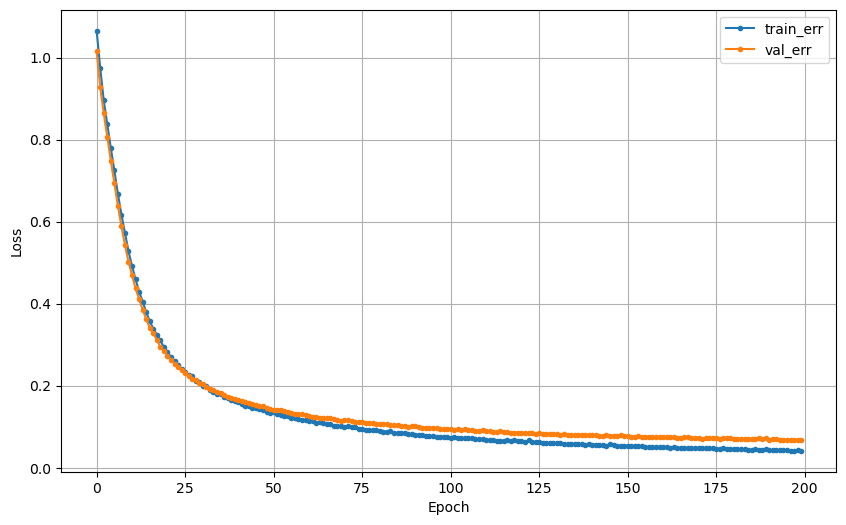

In [188]:
dl_history_plot(hist_dynamic)

In [189]:
pred_dl_dynamic = model_dl_dynamic.predict(x_dynamic_test)
pred_dl_dynamic = pred_dl_dynamic.argmax(axis=1)
print(confusion_matrix(y_dynamic_test, pred_dl_dynamic))
print(classification_report(y_dynamic_test, pred_dl_dynamic))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[294   5   1]
 [  6 260   0]
 [  3   1 225]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.98      0.98      0.98       266
           2       1.00      0.98      0.99       229

    accuracy                           0.98       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.98      0.98      0.98       795



In [190]:
pred_Dl = model_dl_dynamic.predict(x_dt)
pred_Dl = pred_Dl.argmax(axis=1)
print(confusion_matrix(y_d, pred_Dl))
print(classification_report(y_d, pred_Dl))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[223   5   0]
 [ 15 199   1]
 [ 13   1 181]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       228
           1       0.97      0.93      0.95       215
           2       0.99      0.93      0.96       195

    accuracy                           0.95       638
   macro avg       0.95      0.94      0.95       638
weighted avg       0.95      0.95      0.95       638



* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

In [ ]:
# 방법1
def pi_model(model1, model21, model22, x_test):
    li = []
    for data in x_test:
        temp = -1
        pred1 = model1.predict(data)
        
        if pred1 == 0:
            temp = model21.predict(data)
        else:
            temp = model22.predict(data)
        li.append(temp)
    return li

# 방법 2
def pi_model(model1, model21, model22, x_test, x_static_test, x_dynamic_test):
        pred1 = model1.predict(x_test)
        if pred1 == 0:
            pred2 = model21.predict(x_static_test)
        else:
            pred3 = model22.predict(x_static_test)
        print(classification_report(y_test, pred2+pred3))
        
# 둘다 안될 수 있음